In [2]:
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.autograd import Variable
from matplotlib import pyplot as plt
import numpy as np

In [3]:
def set_default(figsize=(10, 10), dpi=100):
    plt.style.use(['dark_background', 'bmh'])
    plt.rc('axes', facecolor='k')
    plt.rc('figure', facecolor='k')
    plt.rc('figure', figsize=figsize, dpi=dpi)

import matplotlib.style
import matplotlib as mpl
# mpl.style.use('classic')
mpl.rcParams['image.cmap'] = 'viridis'


def display_images(in_, out, label, n=1, count=False):
    title_set = False
    for N in range(n):
      if in_ is not None:
        in_pic = in_.data.cpu().view(-1, 28, 28)
        plt.figure(figsize=(18, 4))
        if not title_set:
          plt.suptitle(label, color='w', fontsize=20)
          title_set = True
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(in_pic[i+4*N])
            plt.axis('off')
      if out is not None:
        out_pic = out.data.cpu().view(-1, 28, 28)
        plt.figure(figsize=(18, 6))
        if not title_set:
          plt.suptitle(label, color='w', fontsize=20)
          title_set = True
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(out_pic[i+4*N])
            plt.axis('off')
            if count: plt.title(str(4 * N + i), color='w')

def plot_samples_grid(ds_loader, n_rows=8, n_cols=8, fig_size=8, img_dim=28, title=None):
  
  f, axarr = plt.subplots(n_rows, n_cols, figsize=(fig_size, fig_size))

  images, labels = next(iter(ds_loader))

  for i, ax in enumerate(axarr.flat):
      ax.imshow(images[i].view(img_dim, img_dim))
      ax.axis('off')
      
  plt.suptitle(title)
  plt.show()

In [4]:
# set random seeds
torch.manual_seed(1)
torch.cuda.manual_seed(1)

# setup device cuda vs. cpu
cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")

In [5]:
# set batch size
batch_size = 256

In [6]:
# transformation to apply to each data point (image)
transformer = lambda x: transforms.ToTensor()(x)

# define the train and test datasets
ds_train = MNIST("./data", train=True, transform=transformer, download=True)
ds_test = MNIST("./data", train=False, transform=transformer)

# data loaders to load data in batches from the datasets
train_loader = DataLoader(dataset=ds_train, batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=cuda)
test_loader = DataLoader(dataset=ds_test, batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=cuda)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [7]:

# transformation to apply to each data point (image)
transformer = lambda x: transforms.ToTensor()(x)

# define the train and test datasets
ds_train = MNIST("./data", train=True, transform=transformer, download=True)
ds_test = MNIST("./data", train=False, transform=transformer)

# data loaders to load data in batches from the datasets
train_loader = DataLoader(dataset=ds_train, batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=cuda)
test_loader = DataLoader(dataset=ds_test, batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=cuda)

In [8]:
def binarizer(x):
  intensities = transforms.ToTensor()(x)
  t = torch.Tensor([0.5])
  out = (intensities >= t).float() * 1
  return out

# define the train and test datasets
bin_ds_train = MNIST("./bin_data", train=True, transform=binarizer, download=True)
bin_ds_test = MNIST("./bin_data", train=False, transform=binarizer)

# data loaders to load data in batches from the datasets
bin_train_loader = DataLoader(dataset=bin_ds_train, batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=cuda)
bin_test_loader = DataLoader(dataset=bin_ds_test, batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=cuda)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./bin_data/MNIST/raw/train-images-idx3-ubyte.gz to ./bin_data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./bin_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./bin_data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./bin_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./bin_data/MNIST/raw




Extracting ./bin_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./bin_data/MNIST/raw

Processing...
Done!


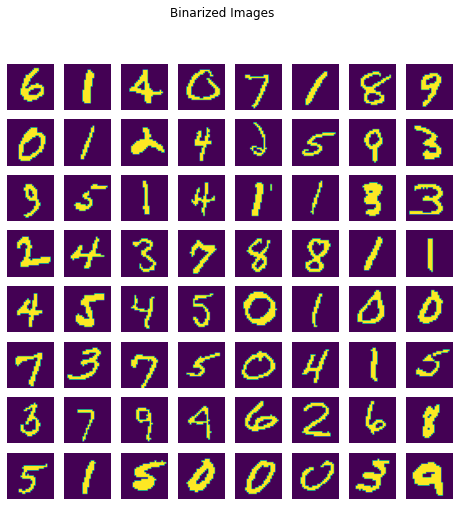

In [9]:
plot_samples_grid(bin_train_loader, title='Binarized Images')

In [10]:
# hyper params
latent_size = 20

In [11]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(784, latent_size ** 2),
            nn.ReLU(),
            nn.Linear(latent_size ** 2, latent_size * 2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_size, latent_size ** 2),
            nn.ReLU(),
            nn.Linear(latent_size ** 2, 784),
            nn.Sigmoid(),
        )

    def reparameterise(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = std.data.new(std.size()).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

    def encode(self, x):
      mu_logvar = self.encoder(x.view(-1, 784)).view(-1, 2, latent_size)
      mu = mu_logvar[:, 0, :]
      logvar = mu_logvar[:, 1, :]
      return mu, logvar

    def decode(self, z):
      return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterise(mu, logvar)
        x_hat = self.decode(z)
        return x_hat, mu, logvar

    def sample(self, n_samples):
      z = torch.randn((n_samples, latent_size)).to(device)
      return self.decode(z)

model = VAE().to(device)

In [12]:
# Setting the optimiser
learning_rate = 1e-3

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)

In [13]:

# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(x_hat, x, mu, logvar):
    
    # reconstruction loss (pushing the points apart)
    BCE = nn.functional.binary_cross_entropy(
        x_hat, x.view(-1, 784), reduction='sum'
    )

    # KL divergence loss (the relative entropy between two distributions a multivariate gaussian and a normal)
    # (enforce a radius of 1 in each direction + pushing the means towards zero)
    KLD = 0.5 * torch.sum(logvar.exp() - logvar - 1 + mu.pow(2))

    return BCE + KLD # we can use a beta parameter here (BCE + beta * KLD)

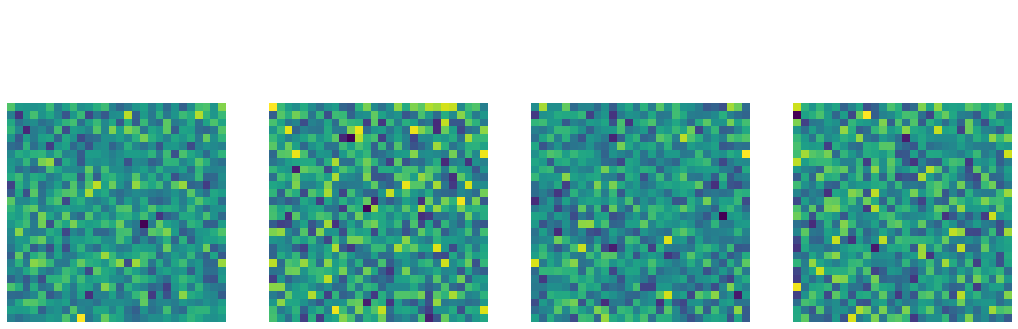

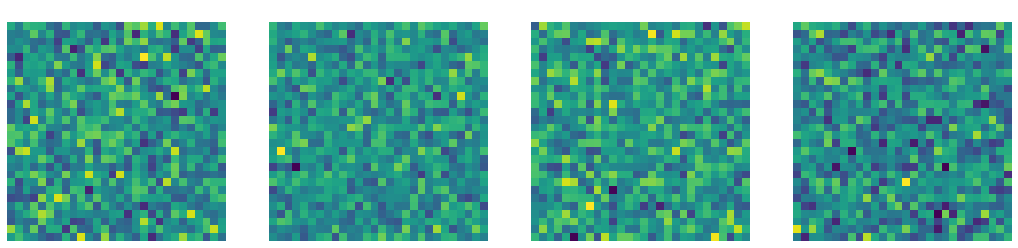

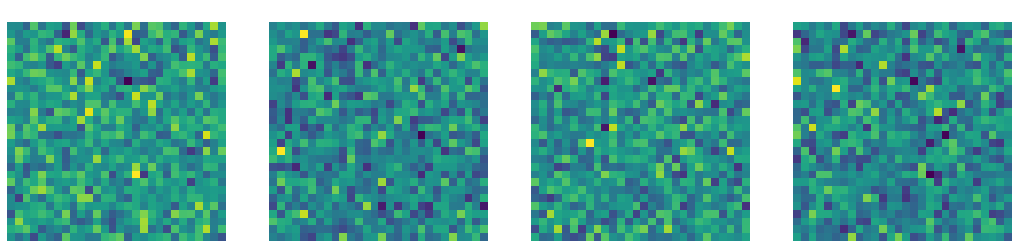

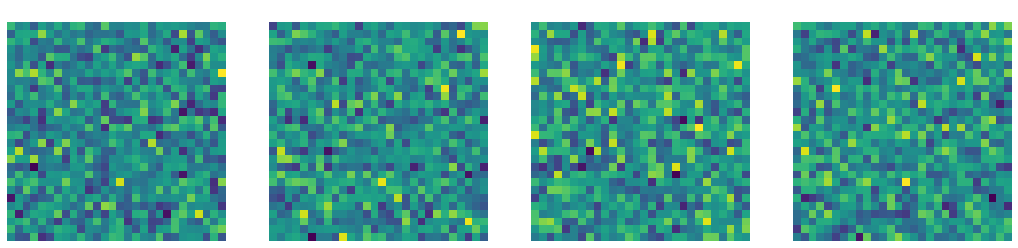

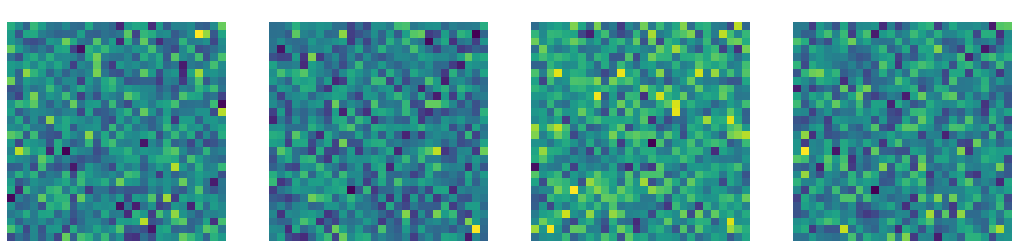

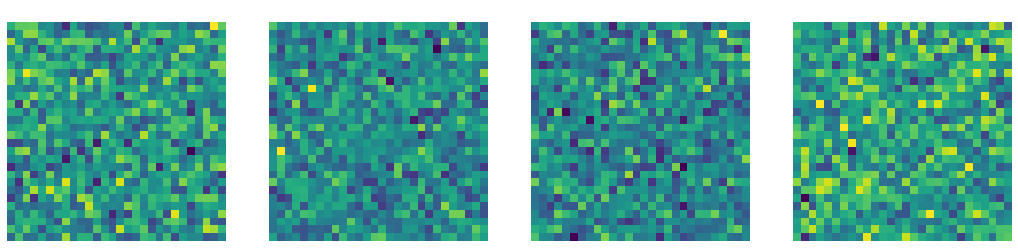

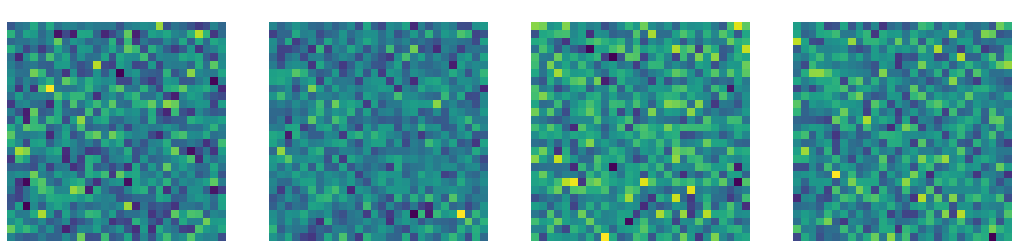

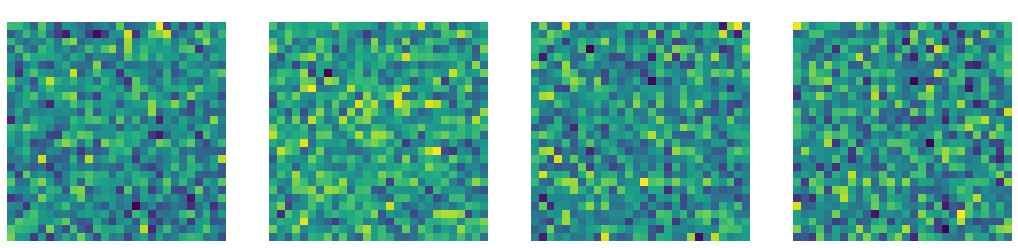

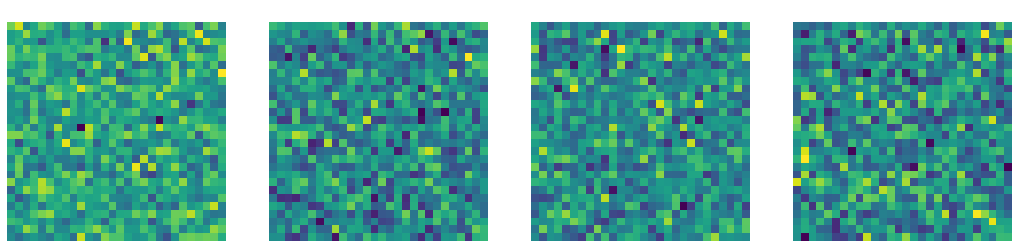

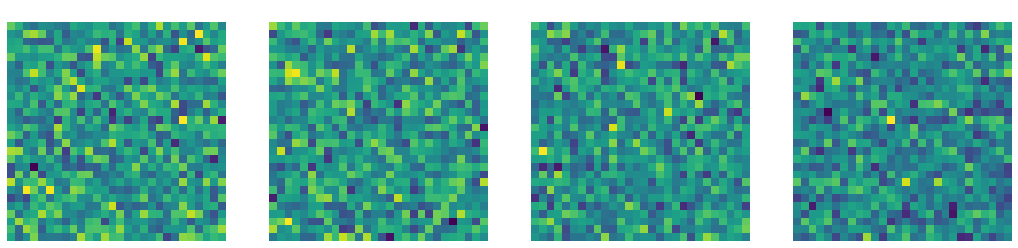

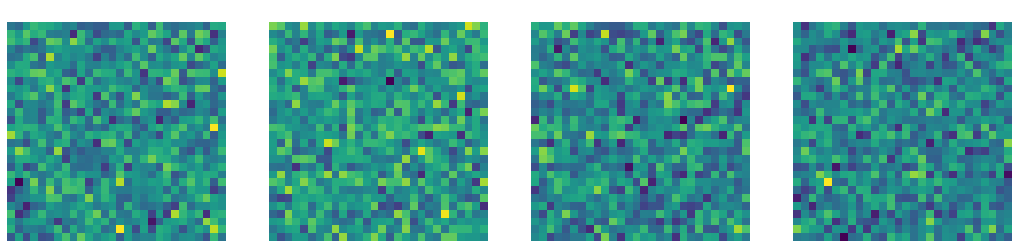

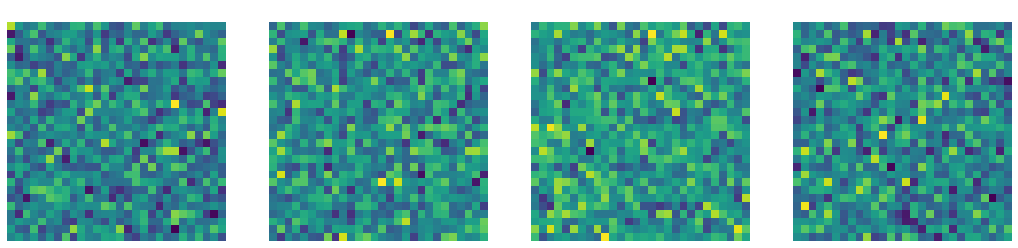

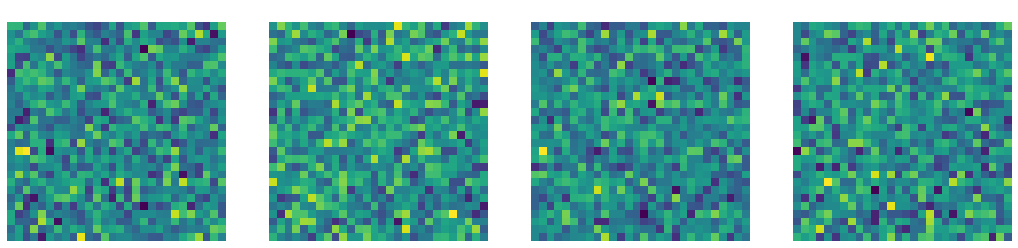

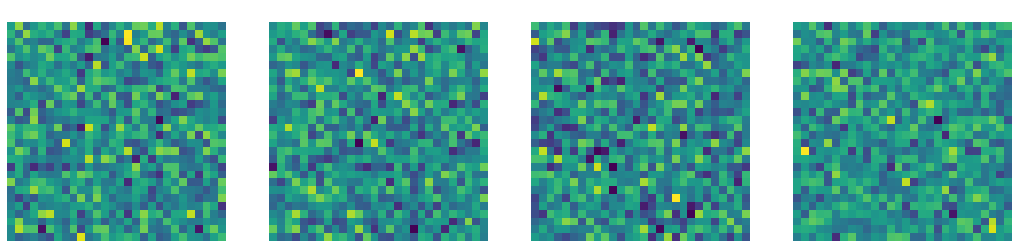

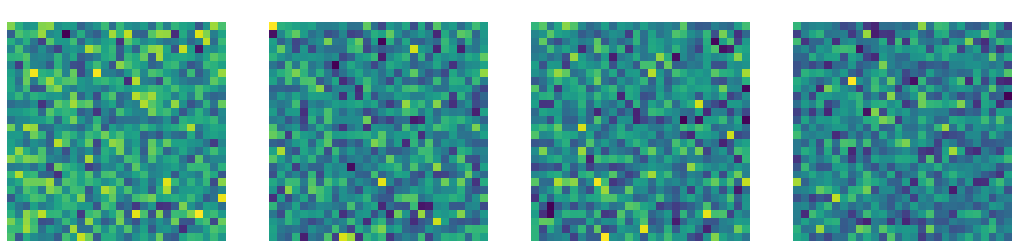

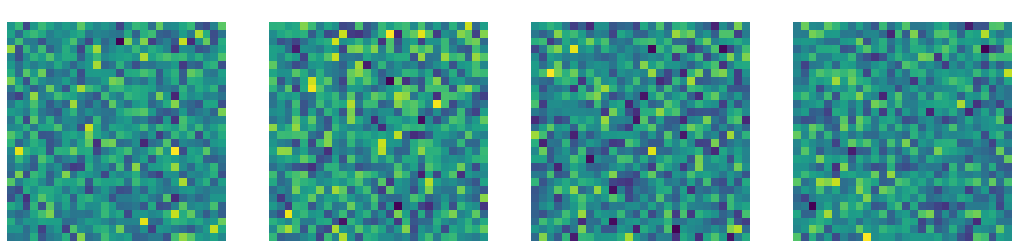

In [14]:
# Generating 64 samples from the untrained model
samples = model.sample(64)
display_images(None, samples, 'Generated Samples - Untrained Model', 64 // 4, count=True)

In [15]:
# Compute the ELBO of 64 samples from the training set using the untrained model
with torch.no_grad():
  model.eval()
  # load a batch (it will be of 256 samples)
  images, _ = next(iter(bin_train_loader))
  # we only want 64 samples
  only_64 = images[0:64, :, :, :]
  # send them to the appropriate device
  only_64 = only_64.to(device)
  # forward
  x_hat, mu, logvar = model(only_64)
  # TODO: there is a miss-match in the dims but the size is the same
  elbo_64_untrained = loss_function(x_hat, only_64, mu, logvar).item()

print(f'ELBO of 64 samples using the untrained model: {elbo_64_untrained:.4f}')

ELBO of 64 samples using the untrained model: 34801.5312


In [16]:
# performs one epoch of training and returns the training loss for this epoch
def train():
  model.train()
  train_loss = 0
  for x, _ in bin_train_loader:
    x = x.to(device)
    # ===================forward=====================
    x_hat, mu, logvar = model(x)
    loss = loss_function(x_hat, x, mu, logvar)
    train_loss += loss.item()
    # ===================backward====================
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  return train_loss

# evaluates the model on the test set
def test(epoch):
  means, logvars, labels, images = list(), list(), list(), list()
  test_loss = 0
  with torch.no_grad():
    model.eval()
    for x, y in bin_test_loader:
      x = x.to(device)
      # forward
      x_hat, mu, logvar = model(x)
      test_loss += loss_function(x_hat, x, mu, logvar).item()
      # log
      means.append(mu.detach())
      logvars.append(logvar.detach())
      labels.append(y.detach())
      images.append(x.detach())
  display_images(None, x_hat, f'Epoch {epoch} - Reconstructed Images', 1)
  return test_loss, means, logvars, labels, images

====> Epoch: 1 Average train loss: 183.2527
====> Epoch: 1 Average test loss: 124.7203
====> Epoch: 2 Average train loss: 121.2759
====> Epoch: 2 Average test loss: 102.6599
====> Epoch: 3 Average train loss: 107.7357
====> Epoch: 3 Average test loss: 94.7544
====> Epoch: 4 Average train loss: 101.6378
====> Epoch: 4 Average test loss: 89.8560
====> Epoch: 5 Average train loss: 98.1689
====> Epoch: 5 Average test loss: 86.6113
====> Epoch: 6 Average train loss: 95.8944
====> Epoch: 6 Average test loss: 85.5551
====> Epoch: 7 Average train loss: 94.1526
====> Epoch: 7 Average test loss: 84.5357
====> Epoch: 8 Average train loss: 92.8090
====> Epoch: 8 Average test loss: 83.0172
====> Epoch: 9 Average train loss: 91.6796
====> Epoch: 9 Average test loss: 81.1382
====> Epoch: 10 Average train loss: 90.7515
====> Epoch: 10 Average test loss: 81.5994
====> Epoch: 11 Average train loss: 89.9961
====> Epoch: 11 Average test loss: 80.7808
====> Epoch: 12 Average train loss: 89.3749
====> Epoch

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


====> Epoch: 22 Average train loss: 85.6862
====> Epoch: 22 Average test loss: 76.5854
====> Epoch: 23 Average train loss: 85.4301
====> Epoch: 23 Average test loss: 76.7448
====> Epoch: 24 Average train loss: 85.2178
====> Epoch: 24 Average test loss: 77.1767
====> Epoch: 25 Average train loss: 85.0947
====> Epoch: 25 Average test loss: 77.3238
====> Epoch: 26 Average train loss: 84.8048
====> Epoch: 26 Average test loss: 76.4900
====> Epoch: 27 Average train loss: 84.6843
====> Epoch: 27 Average test loss: 76.7161
====> Epoch: 28 Average train loss: 84.4979
====> Epoch: 28 Average test loss: 75.9640
====> Epoch: 29 Average train loss: 84.3132
====> Epoch: 29 Average test loss: 75.8920
====> Epoch: 30 Average train loss: 84.1586
====> Epoch: 30 Average test loss: 76.7016
====> Epoch: 31 Average train loss: 84.0421
====> Epoch: 31 Average test loss: 76.4725
====> Epoch: 32 Average train loss: 83.8962
====> Epoch: 32 Average test loss: 75.6147
====> Epoch: 33 Average train loss: 83.8152

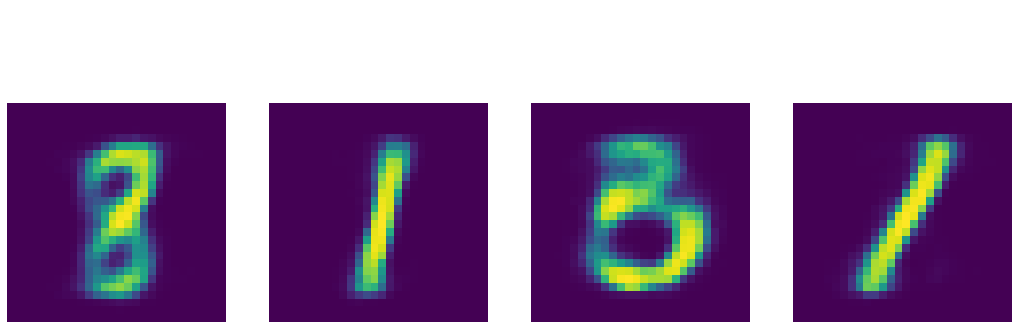

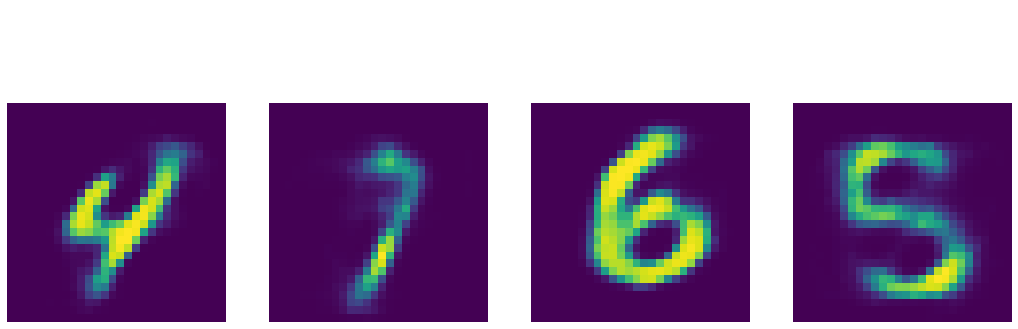

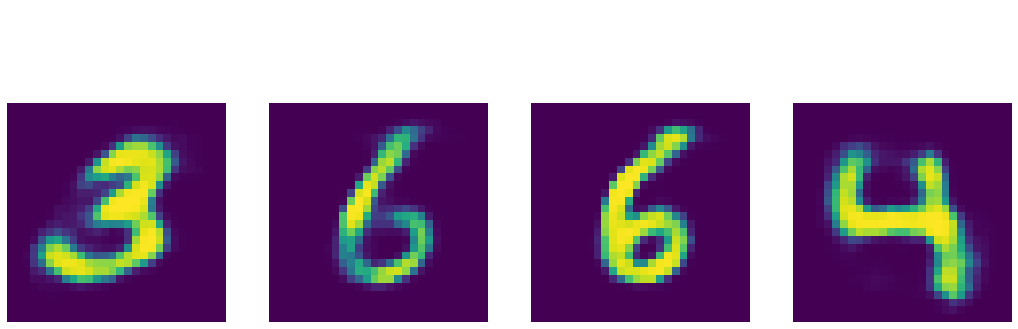

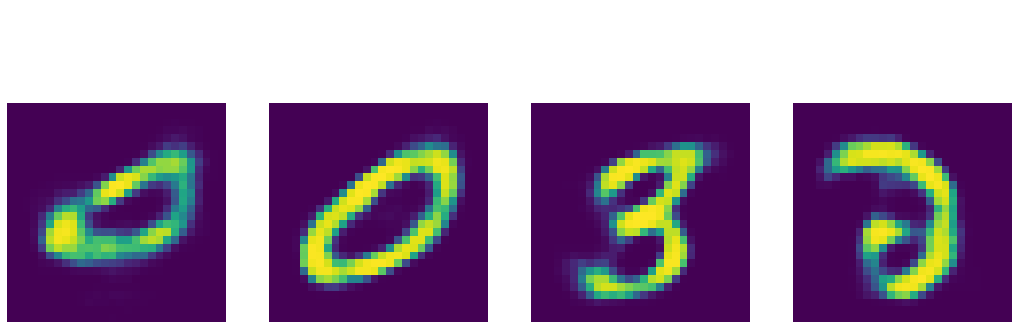

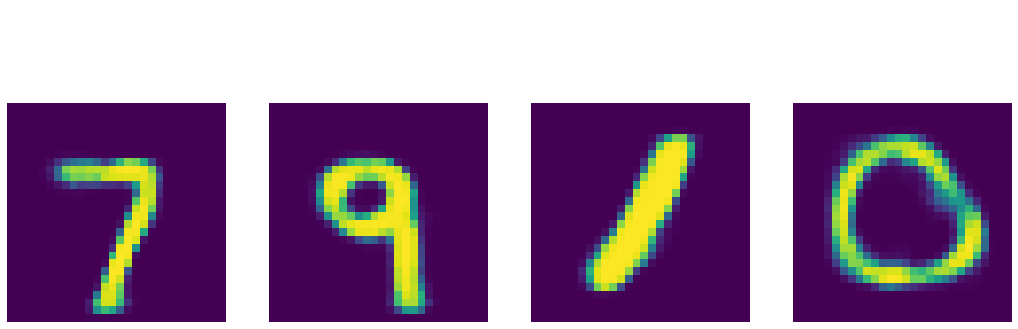

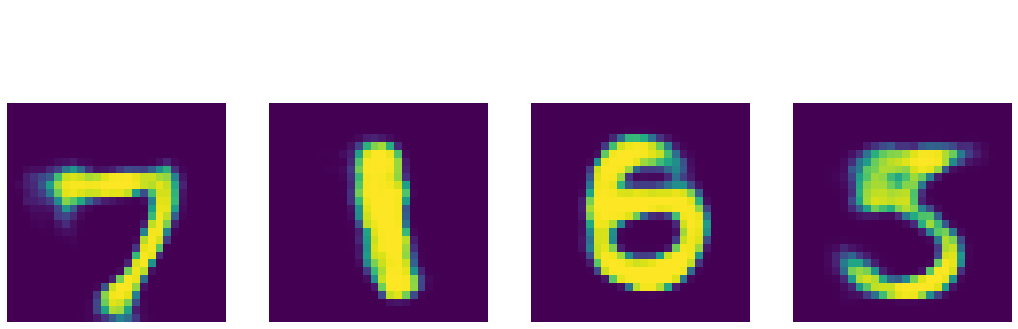

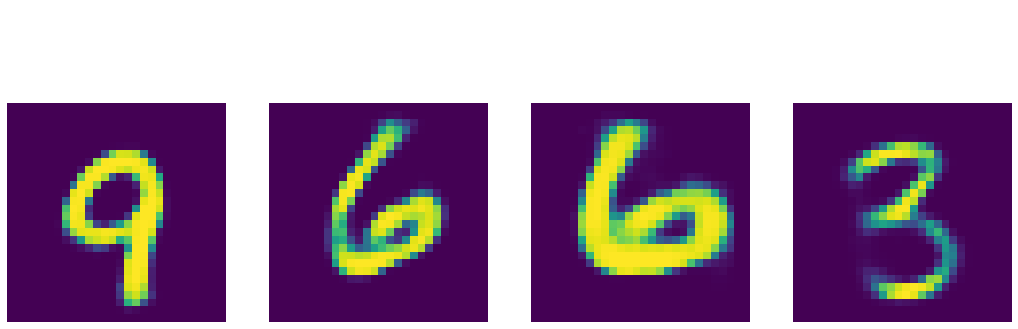

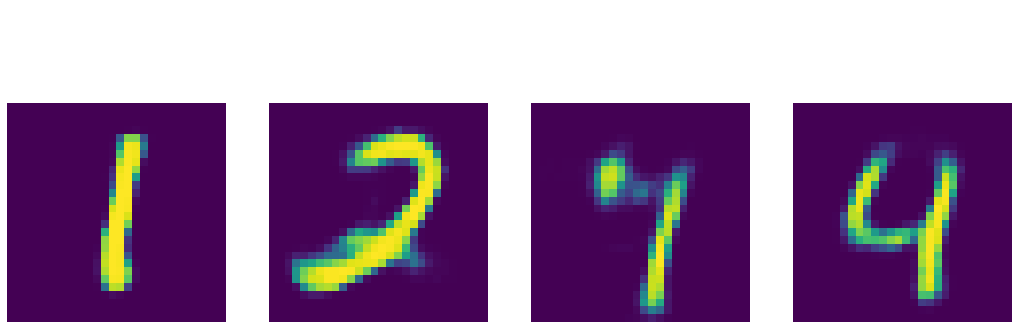

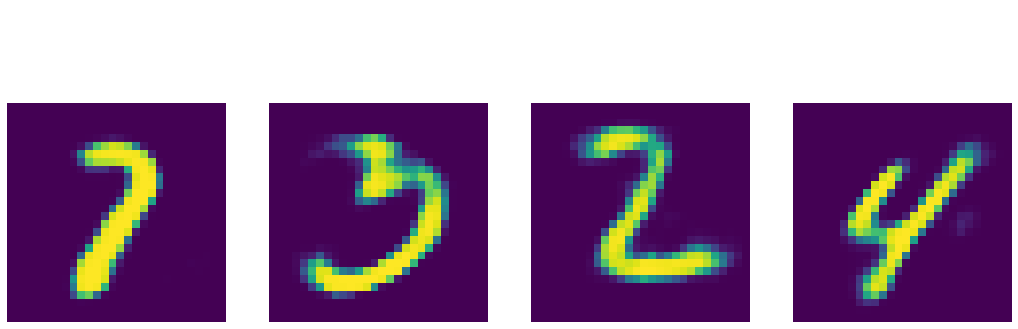

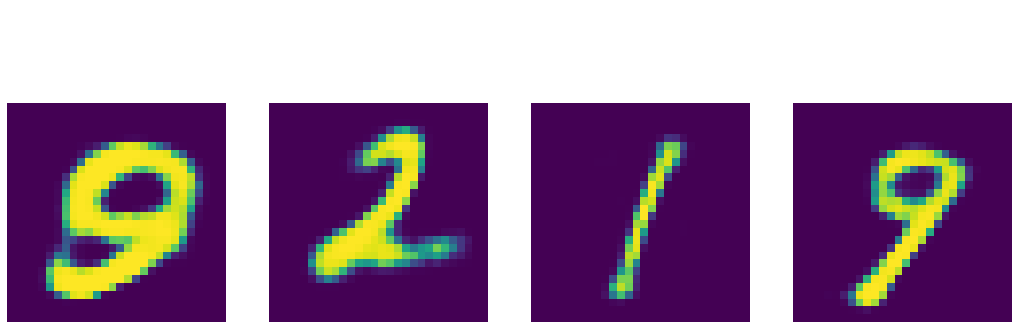

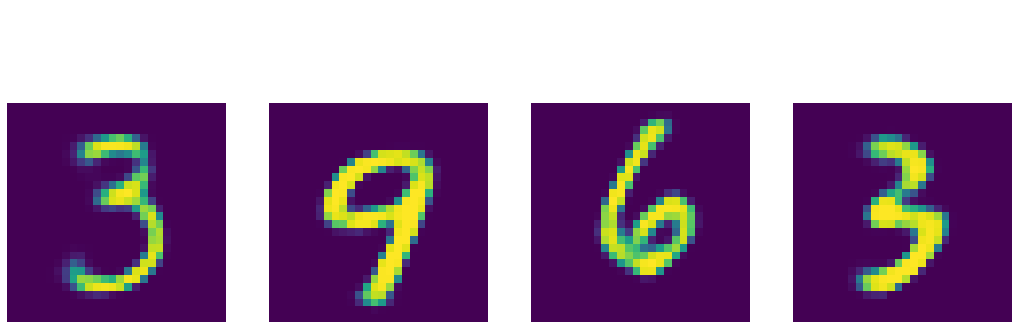

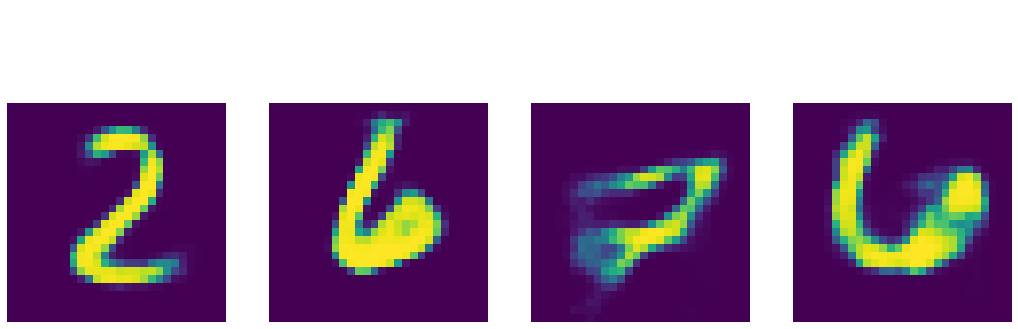

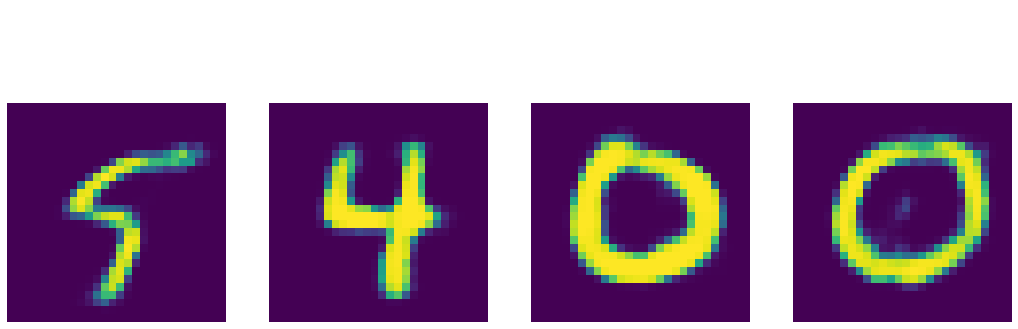

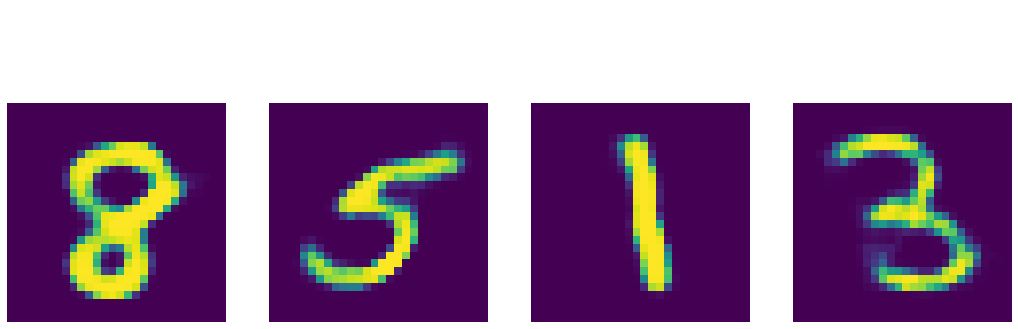

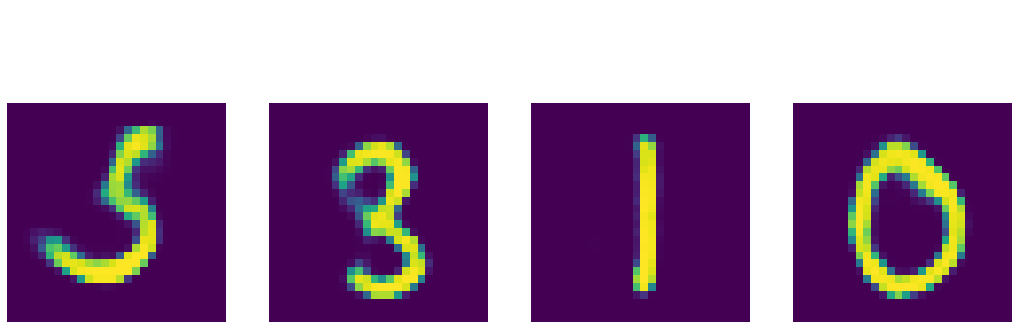

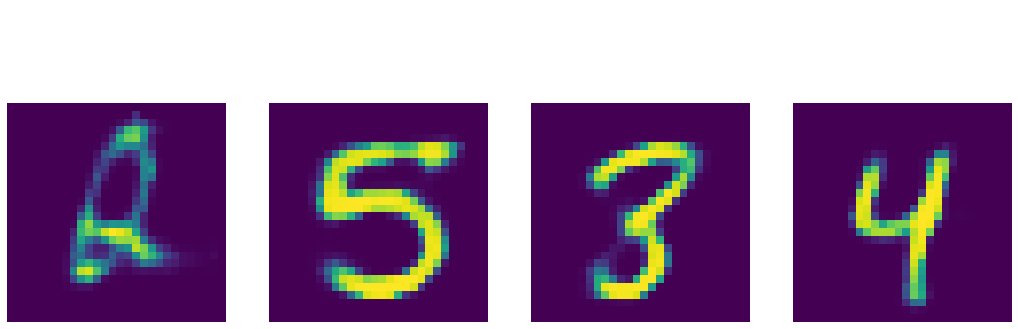

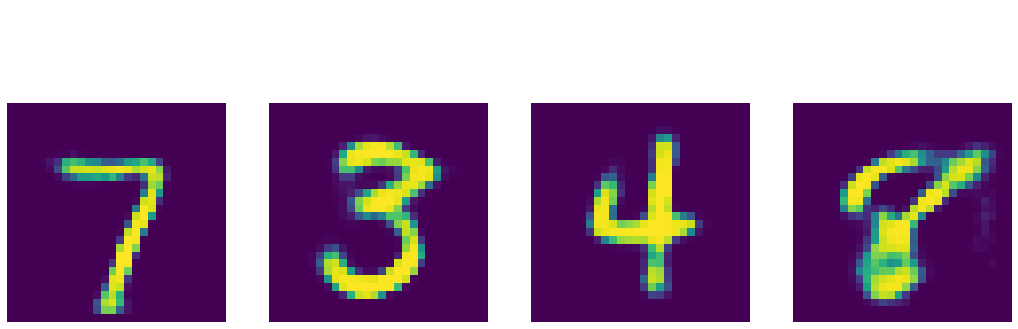

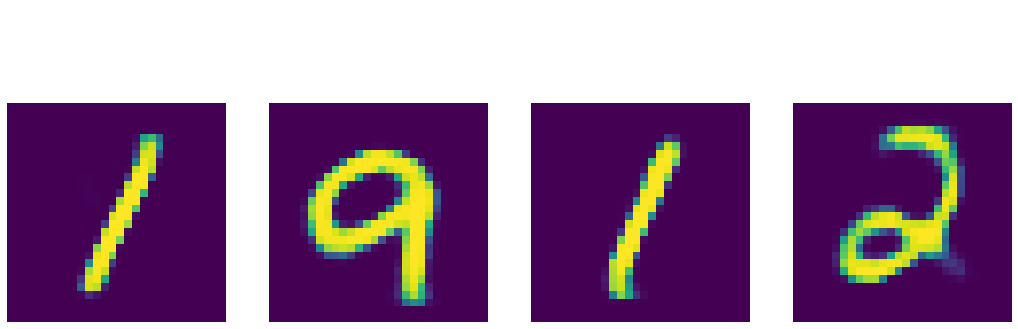

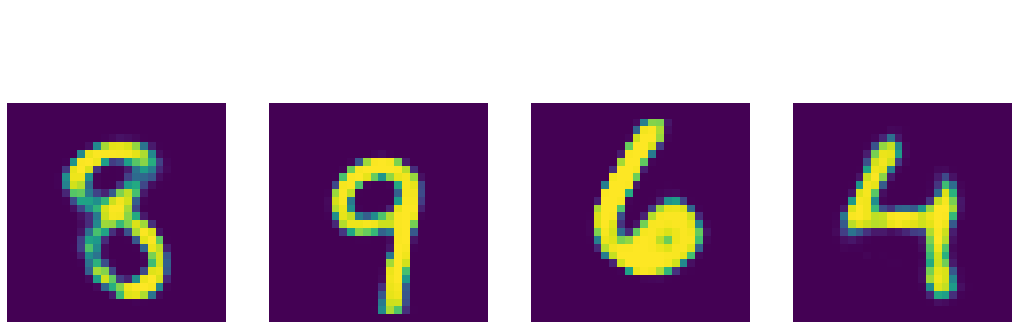

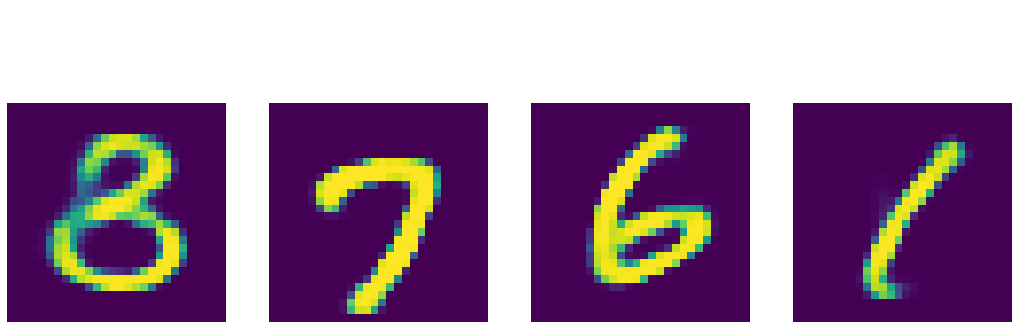

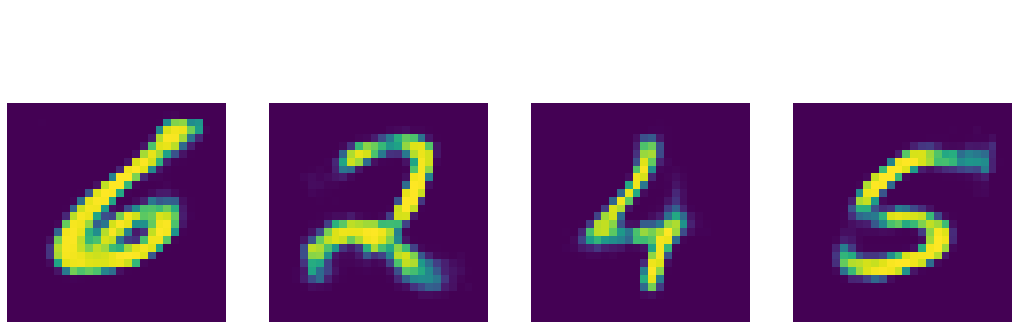

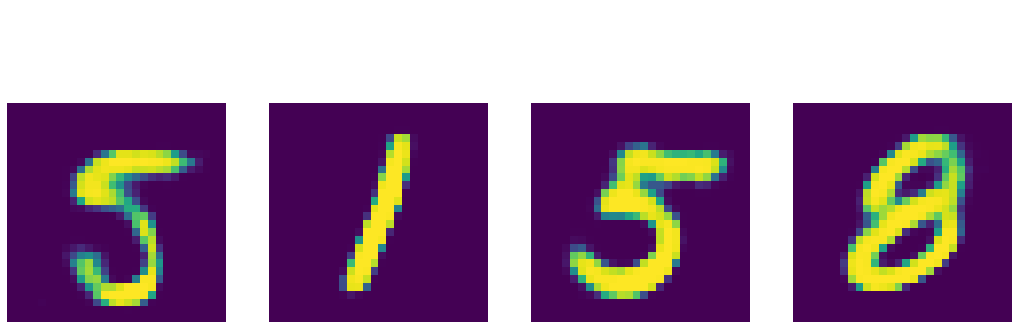

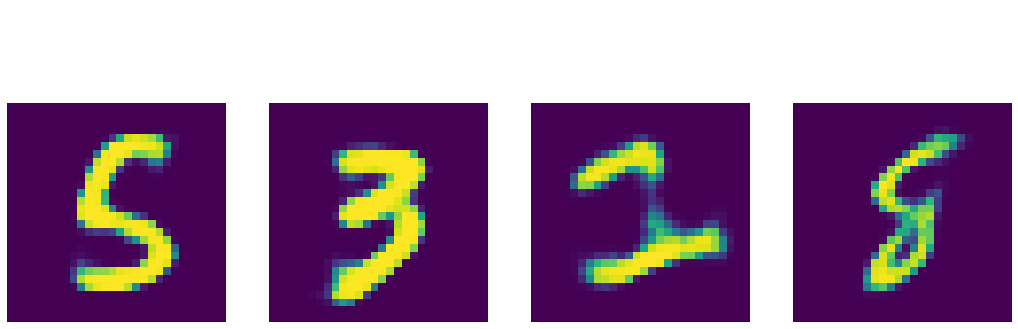

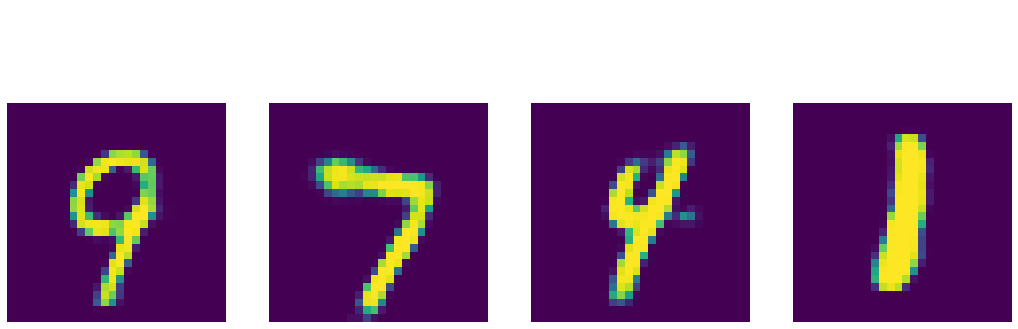

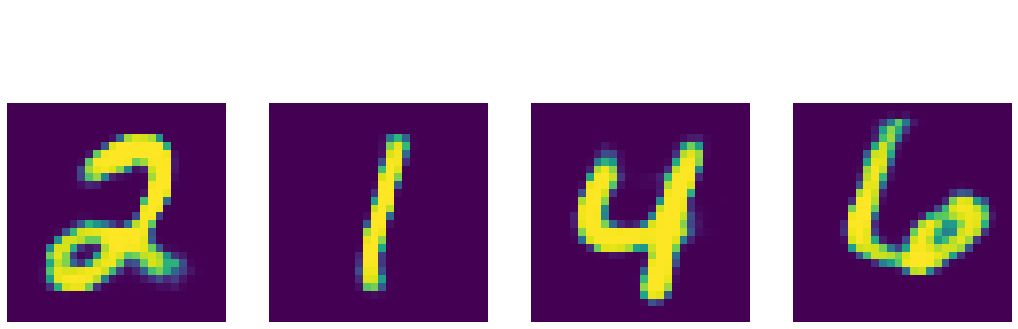

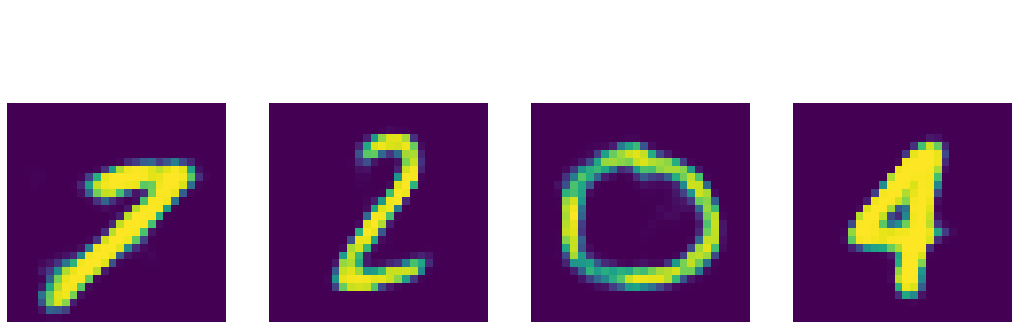

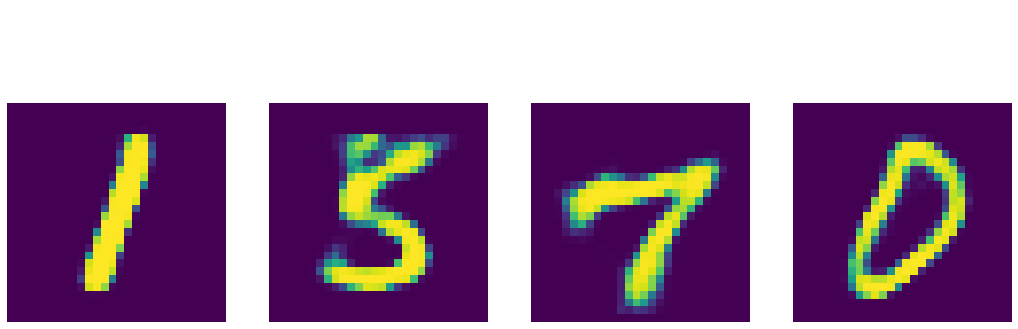

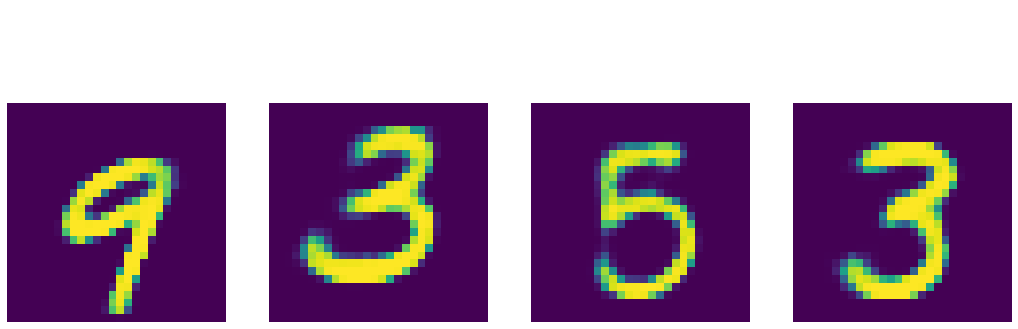

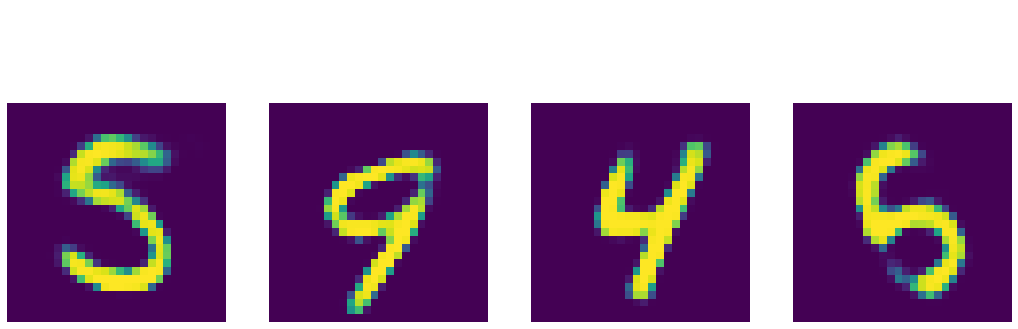

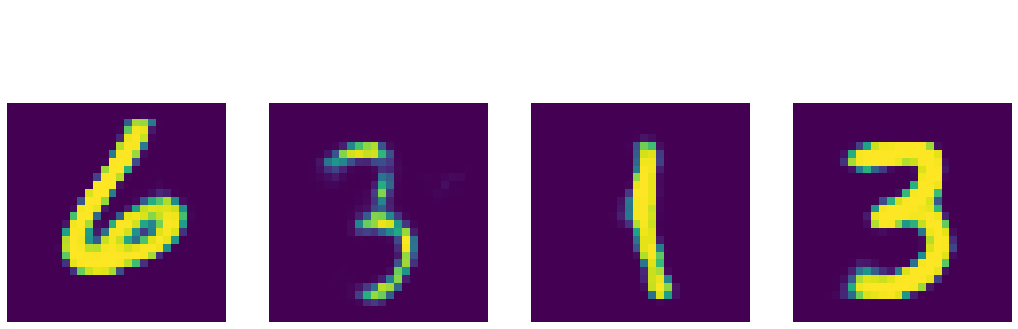

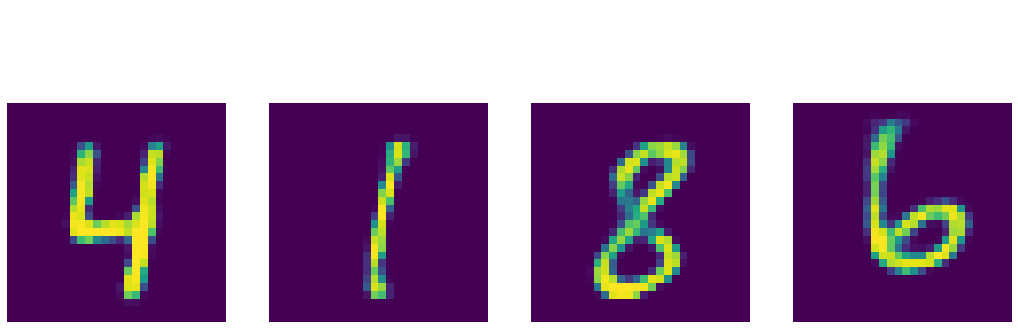

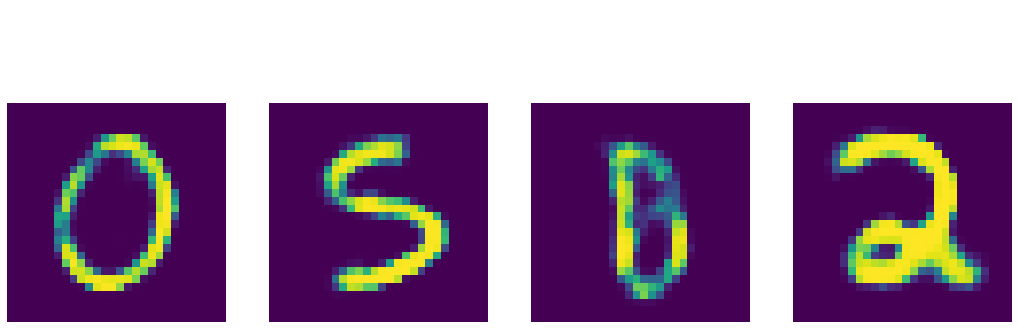

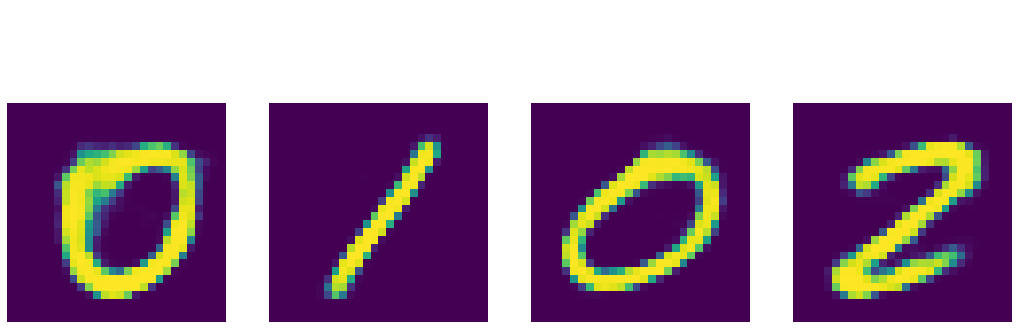

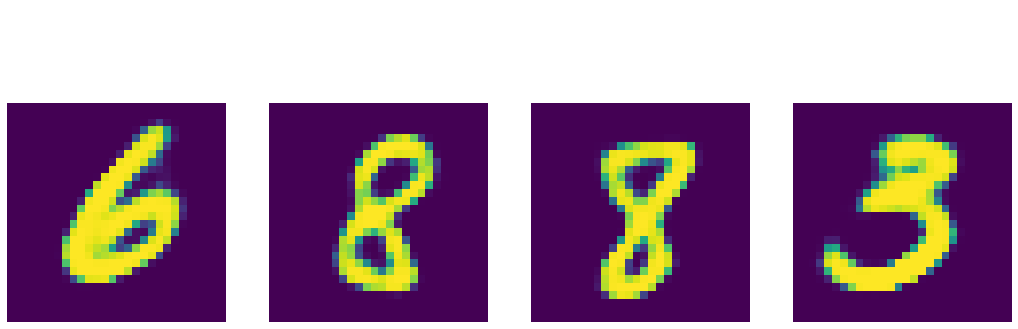

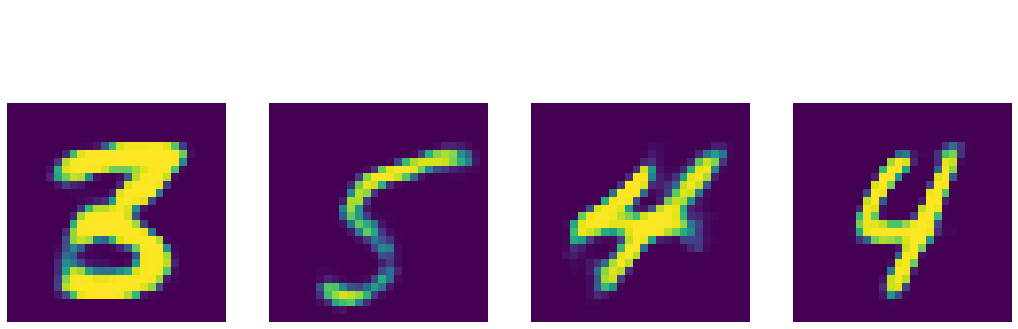

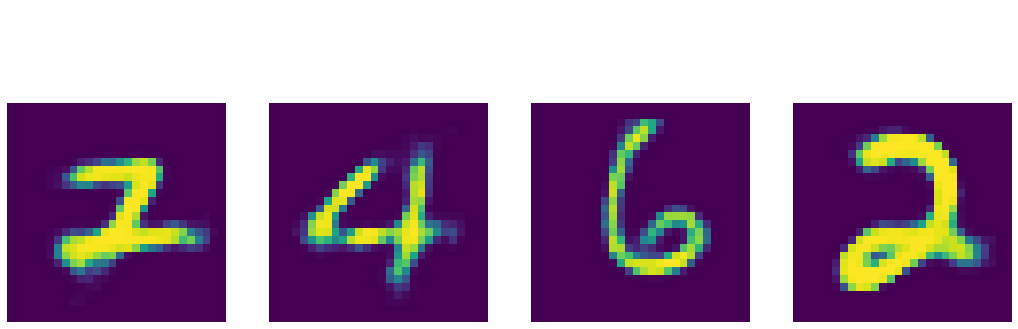

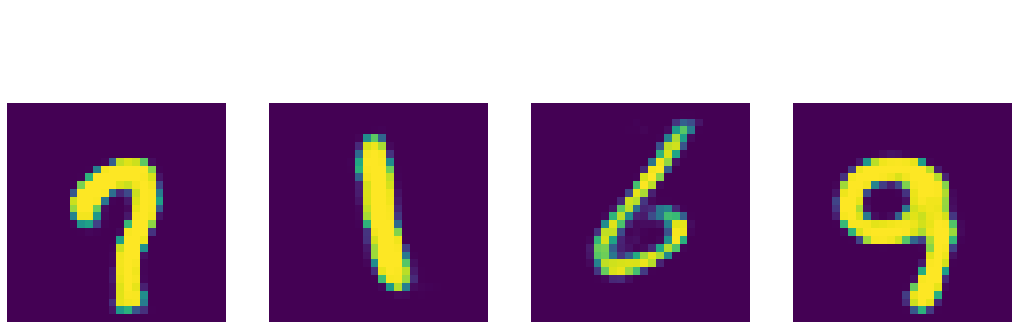

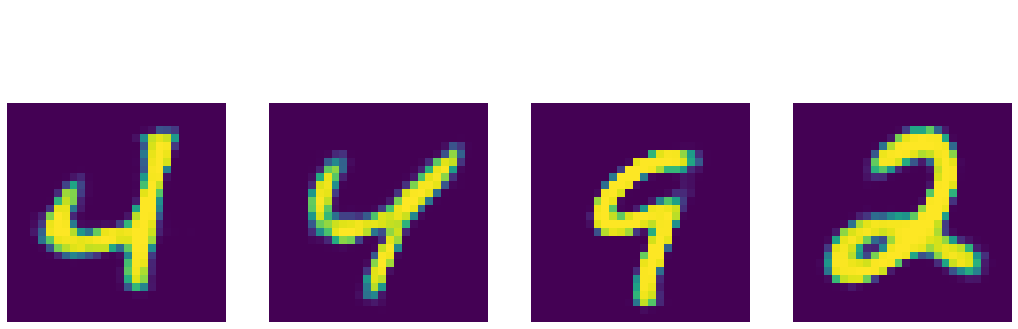

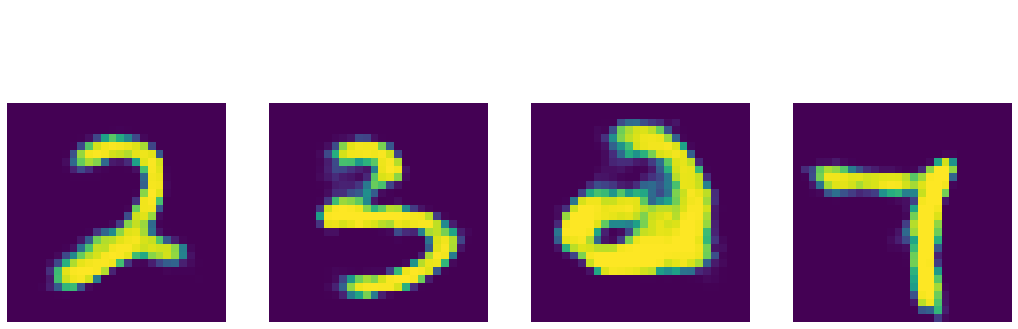

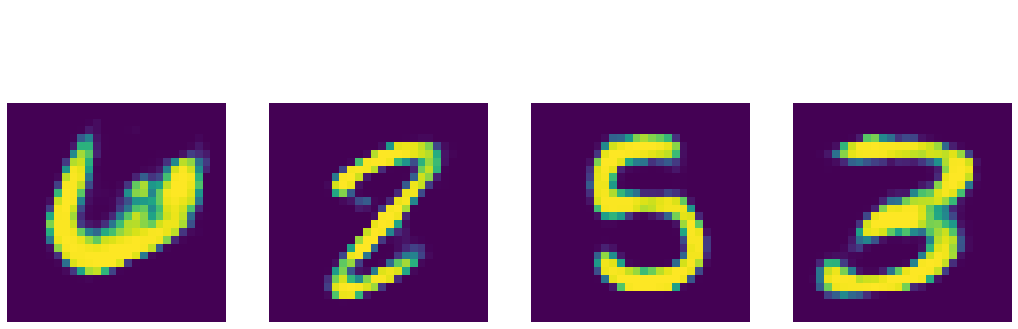

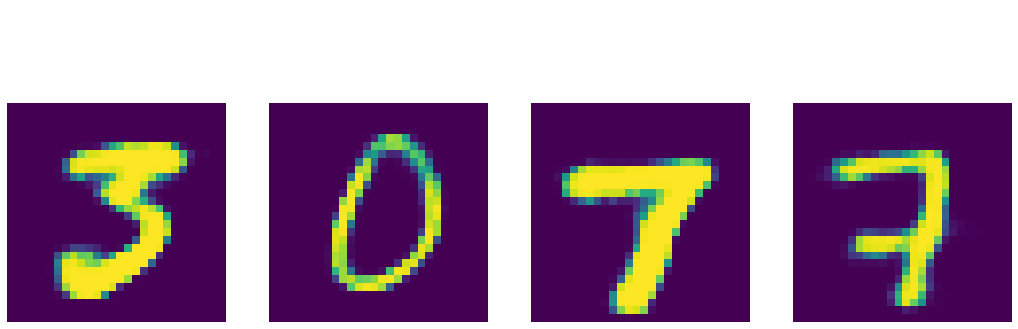

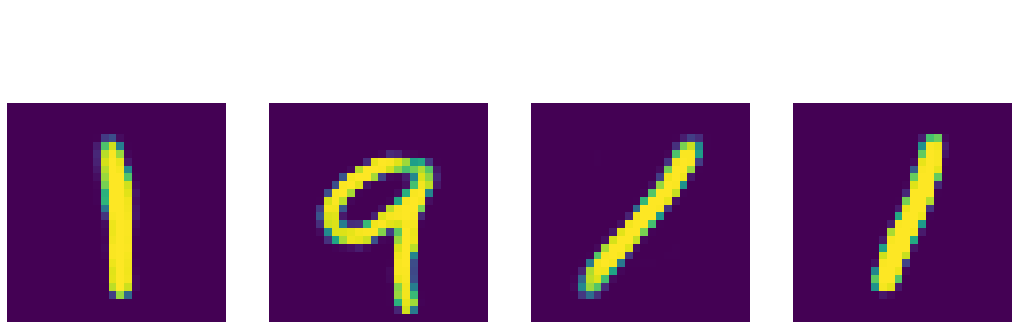

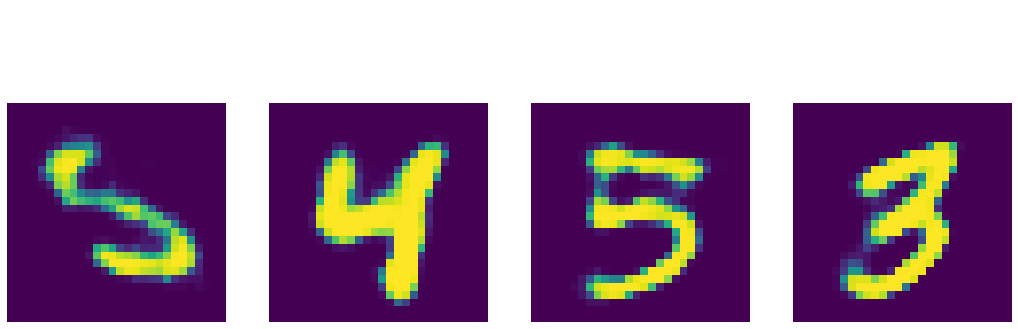

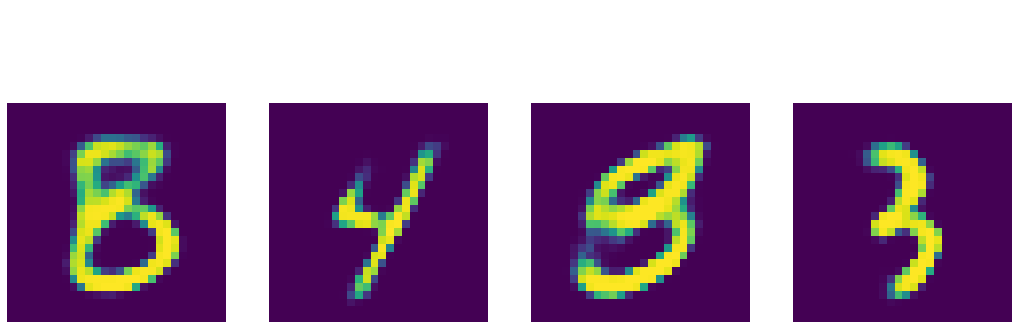

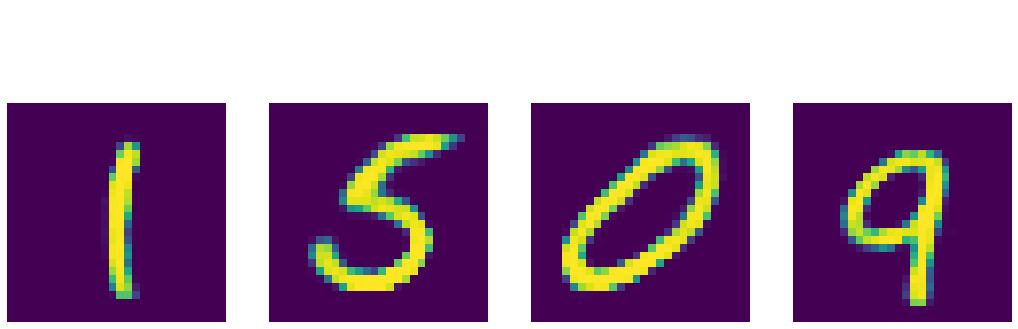

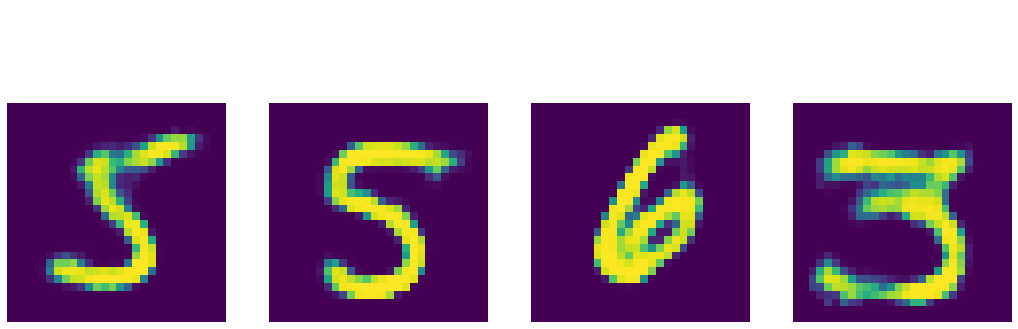

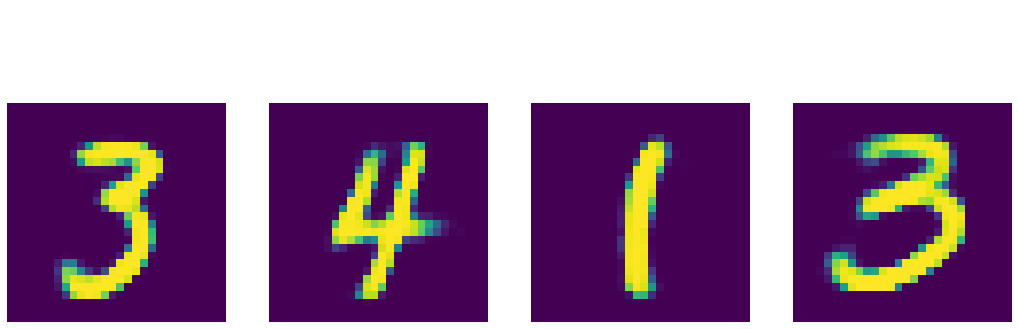

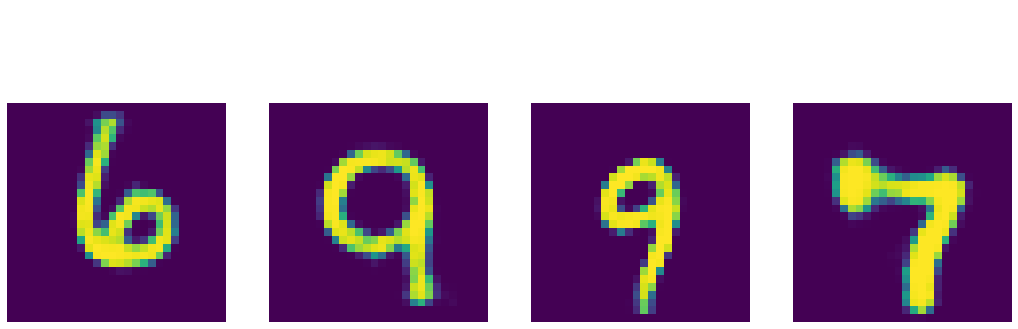

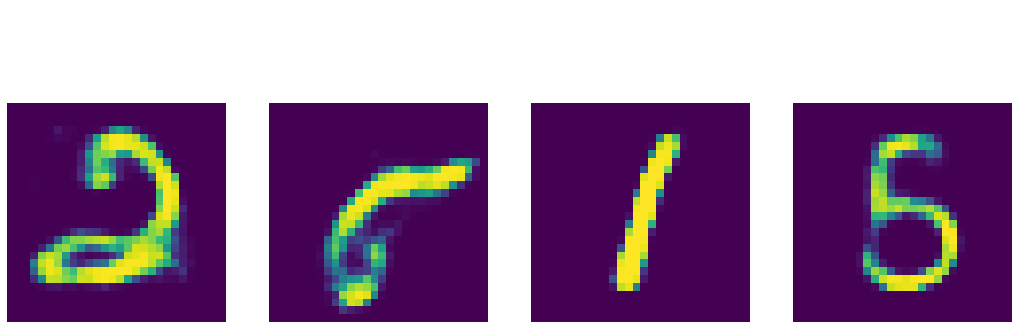

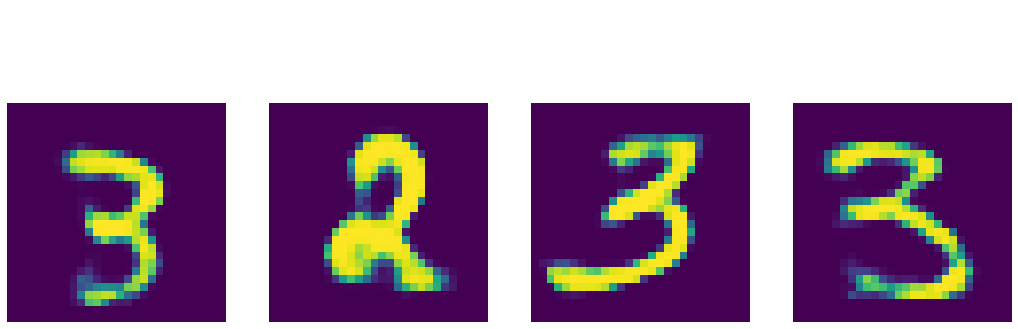

In [17]:

# Training the model
epochs = 50
codes = dict(μ=list(), logσ2=list(), y=list(), x=list())
for epoch in range(1, epochs+1):
    
    # train for one epoch
    train_loss = train()

    # print the train loss for the epoch
    print(f'====> Epoch: {epoch} Average train loss: {train_loss / len(bin_train_loader.dataset):.4f}')
    
    # evaluate this epoch over the test set
    test_loss, means, logvars, labels, images = test(epoch)

    # log for analysis
    codes['μ'].append(torch.cat(means))
    codes['logσ2'].append(torch.cat(logvars))
    codes['y'].append(torch.cat(labels))
    codes['x'].append(torch.cat(images))

    # print the test loss for the epoch
    print(f'====> Epoch: {epoch} Average test loss: {test_loss / len(bin_test_loader.dataset):.4f}')


In [18]:
# save the state dict of the model
torch.save(model.state_dict(), 'vae-model.pt')

In [19]:
# loading a saved module
model = VAE().to(device)
model.load_state_dict(torch.load('vae-model.pt'))

<All keys matched successfully>

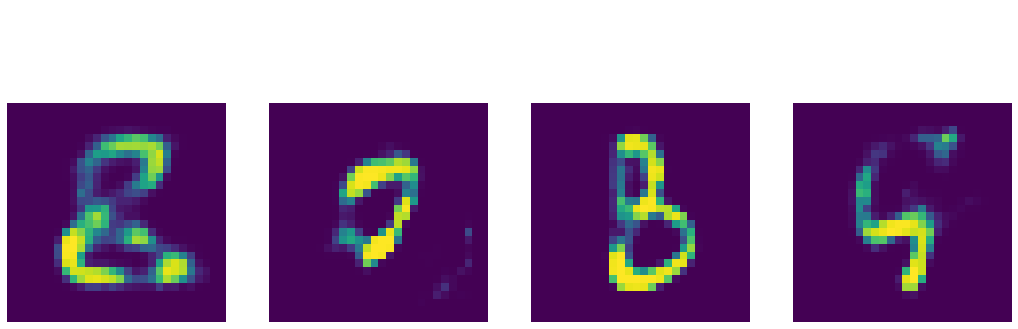

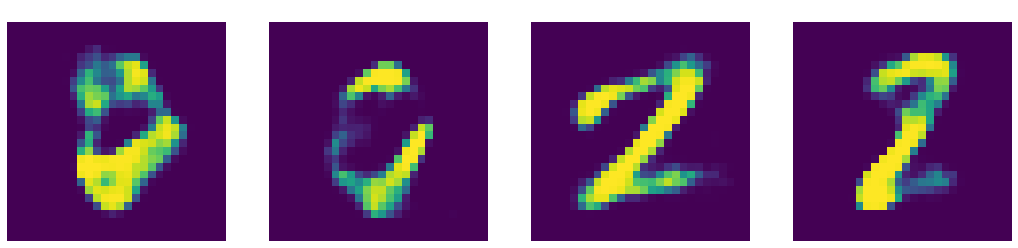

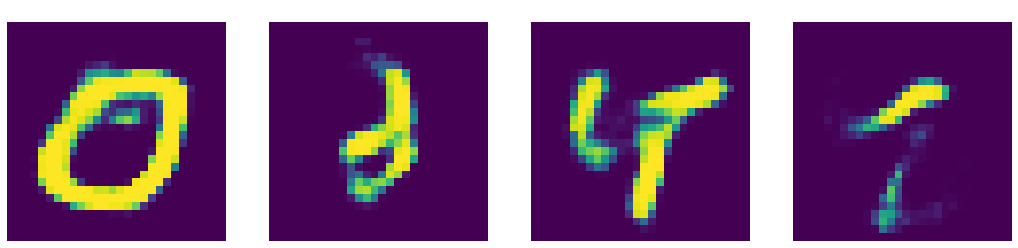

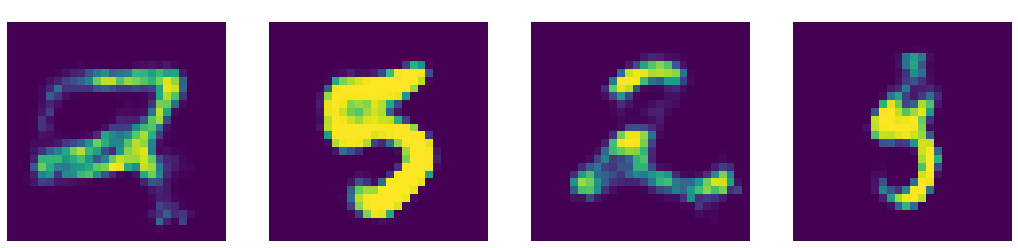

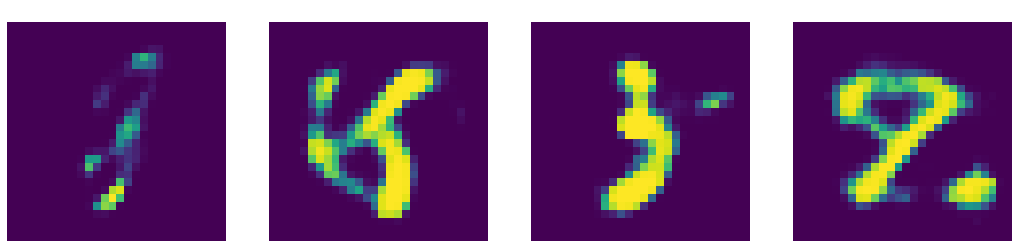

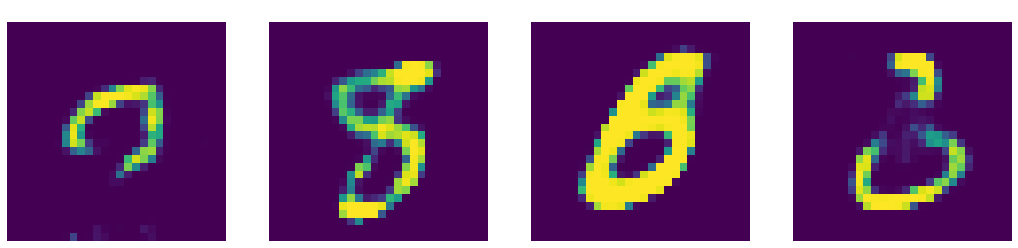

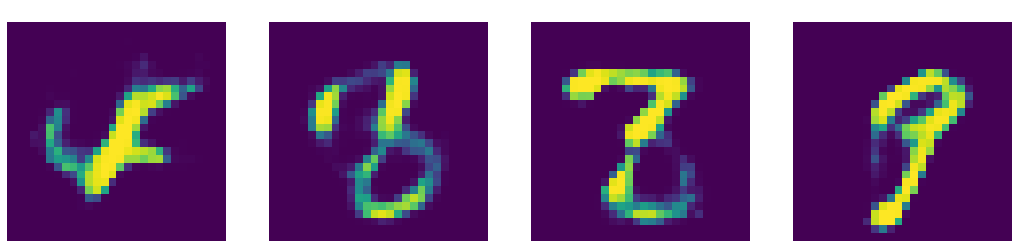

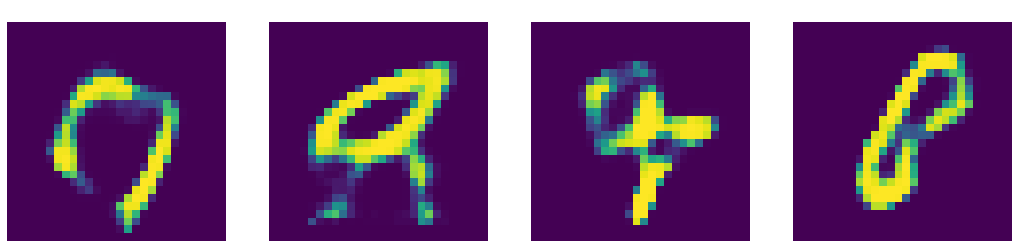

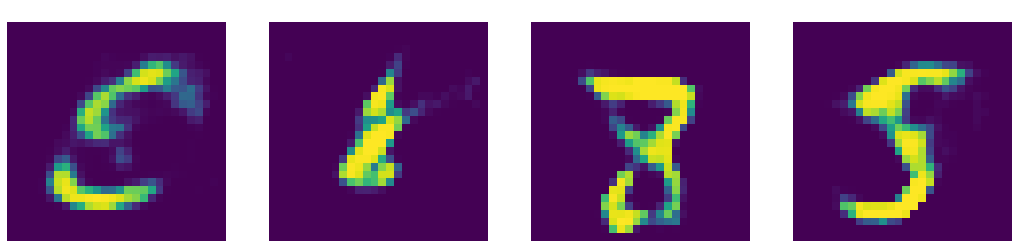

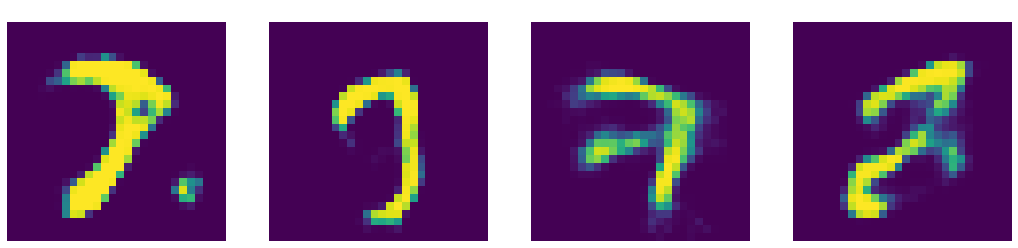

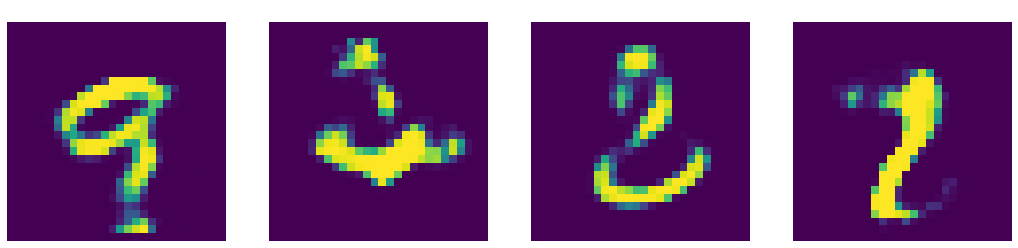

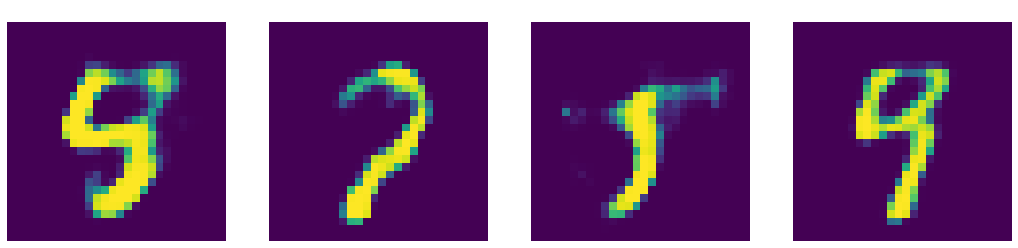

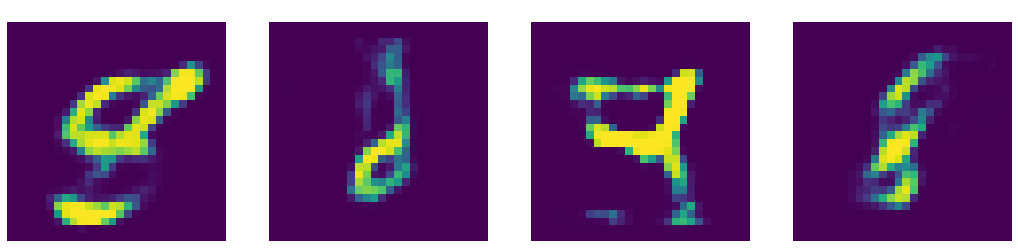

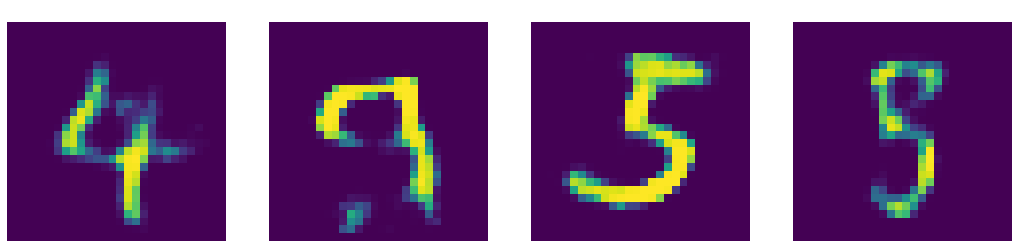

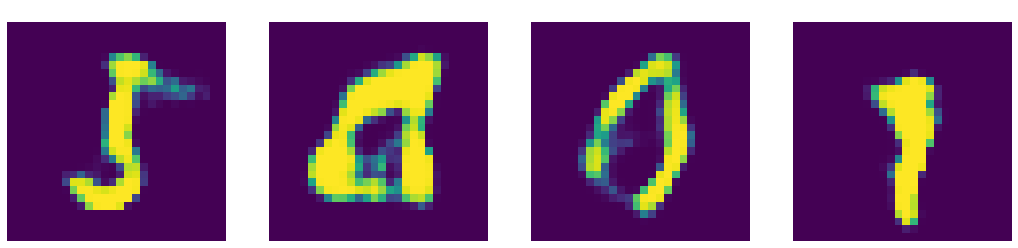

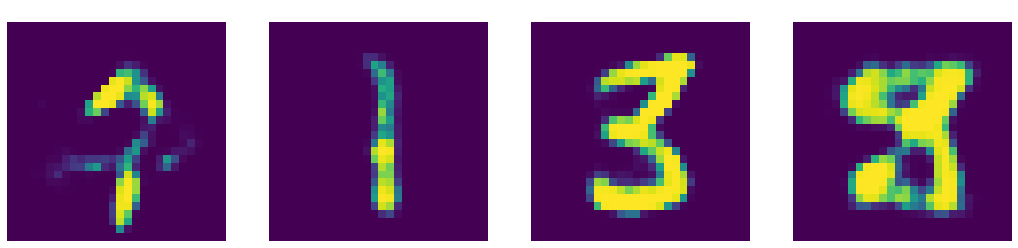

In [20]:
# Generate 64 samples from the trained model and plot them.
samples = model.sample(64)
display_images(None, samples, 'Generated Samples - Trained Model', 64 // 4, count=True)

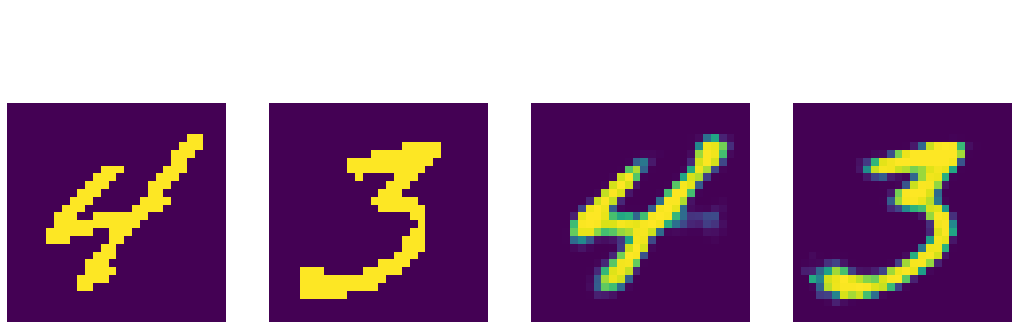

In [21]:

# Choose starting and ending point for the interpolation -> shows original and reconstructed
A, B = 12, 26
sample = model.decoder(torch.stack((codes['μ'][epoch-1][A].data, codes['μ'][epoch-1][B].data), 0))
display_images(None, torch.stack(((
    codes['x'][epoch-1][A].data.view(-1),
    codes['x'][epoch-1][B].data.view(-1),
    sample.data[0],
    sample.data[1]
))), 'Interpolation Start and End')

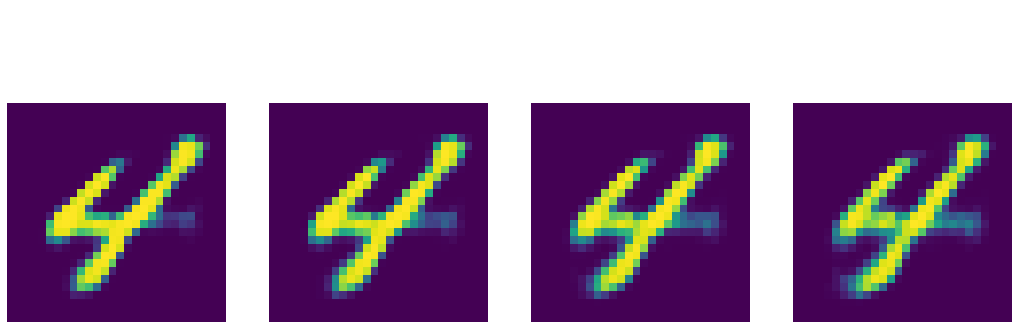

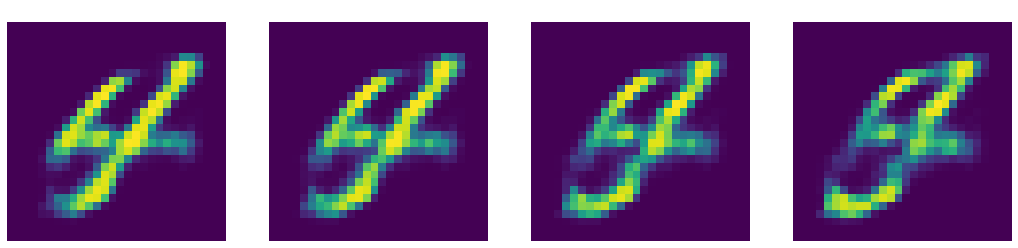

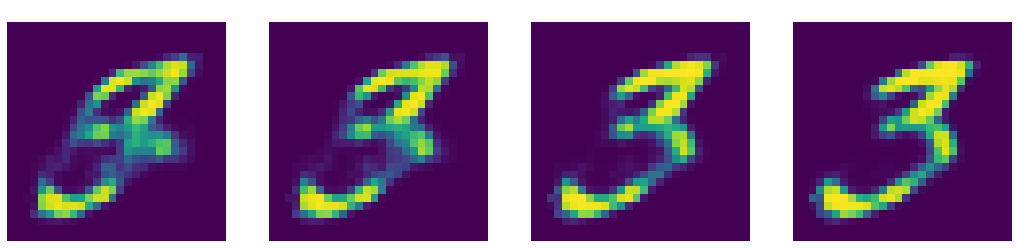

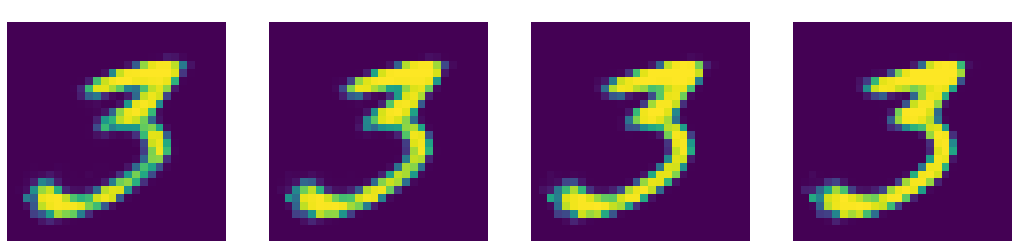

In [22]:
# Perform a linear interpolation between 2 inputs A and B in the latent space and send it through the decoder
# by walking in the latent space we get to reconstruct things that look legit in the input space
N = 16
code = torch.Tensor(N, 20).to(device)
sample = torch.Tensor(N, 28, 28).to(device)
for i in range(N):
    code[i] = i / (N - 1) * codes['μ'][epoch-1][B].data + (1 - i / (N - 1) ) * codes['μ'][epoch-1][A].data
sample = model.decoder(code)
display_images(None, sample, 'Interpolation in N steps', N // 4, count=True)

In [23]:
import numpy as np
from sklearn.manifold import TSNE

In [24]:
X, Y, E = list(), list(), list()  # input, classes, embeddings
N = 1000  # samples per epoch
epochs = (0, 24, 49)
for epoch in epochs:
    X.append(codes['μ'][epoch][:N])
    E.append(TSNE(n_components=2).fit_transform(X[-1]))
    Y.append(codes['y'][epoch][:N])

In [25]:
set_default(figsize=(20, 6))

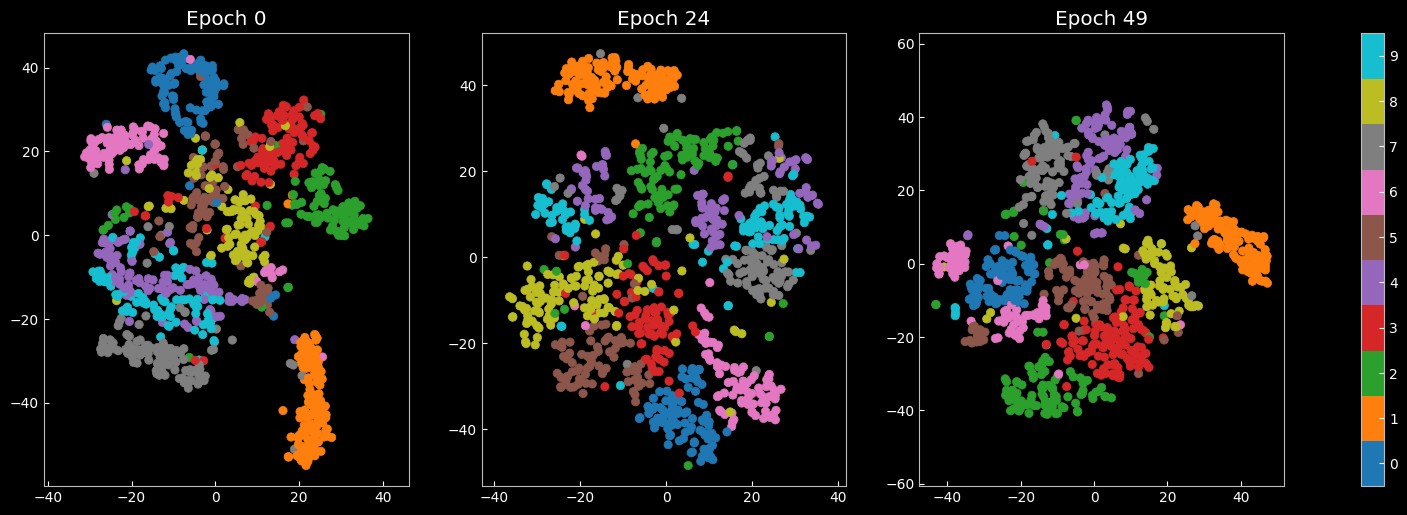

In [26]:
f, a = plt.subplots(ncols=3)
for i, e in enumerate(epochs):
    s = a[i].scatter(E[i][:,0], E[i][:,1], c=Y[i], cmap='tab10')
    a[i].grid(False)
    a[i].set_title(f'Epoch {e}')
    a[i].axis('equal')
f.colorbar(s, ax=a[:], ticks=np.arange(10), boundaries=np.arange(11) - .5)

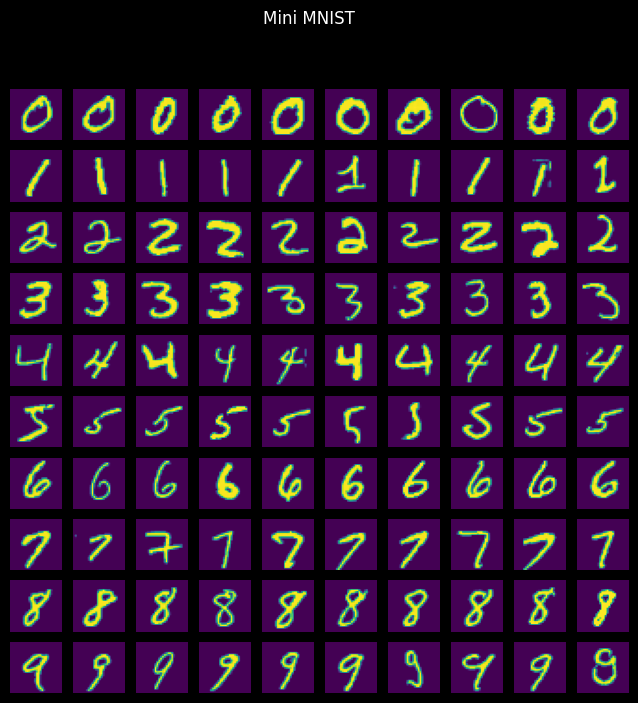

In [27]:
# extract 100 labeled datapoints (10 from each class)
data_list, targets_list = [], []

# take 10 of each class
for class_ in range(10):
  idx = bin_ds_train.targets == class_
  data_list.append(bin_ds_train.data[idx][0:10, :, :])
  targets_list.append(bin_ds_train.targets[idx][0:10])

# convert the lists to tensors
mini_ds_data = torch.cat(data_list, 0)
mini_ds_targets = torch.cat(targets_list, 0)

# make sure the type is correct
mini_ds_data = mini_ds_data.to(dtype=torch.float32)
mini_ds_targets = mini_ds_targets.to(dtype=torch.long)

# create a dataset and a loader
mini_ds = TensorDataset(mini_ds_data, mini_ds_targets)
mini_dl = DataLoader(mini_ds, batch_size=100, drop_last=False, shuffle=False, num_workers=1, pin_memory=cuda)

# plot all the dataset
plot_samples_grid(mini_dl, n_rows=10, n_cols=10, title='Mini MNIST')

In [28]:
with torch.no_grad():
  model.eval()
  for x, _ in mini_dl:
    x = x.to(device)
    # encode
    mu, logvar = model.encode(x)
    # reparameterize (there will be 1 batch only)
    z = model.reparameterise(mu, logvar)

# make sure the type is correct
mini_ds_latent_vectors = z.to(dtype=torch.float32)

In [29]:
# prepare the new mini dataset for training classifiers
latent_mini_ds = TensorDataset(mini_ds_latent_vectors, mini_ds_targets)
latent_mini_dl = DataLoader(latent_mini_ds, batch_size=4, drop_last=False, shuffle=True, num_workers=1, pin_memory=cuda)

In [30]:
# to collect info about the performance of the various classifiers
clf_stats = {}

In [31]:
# a simple linear model
class LinearClassifier(nn.Module):

  def __init__(self):
      super(LinearClassifier, self).__init__()
      
      self.layer_1 = nn.Linear(in_features=latent_size, out_features=10, bias=True)

  def forward(self, x):
    x = x.view(-1, latent_size)
    logits = self.layer_1(x)
    return F.log_softmax(logits, dim=1)

linearClassifier = LinearClassifier()
print(linearClassifier)

LinearClassifier(
  (layer_1): Linear(in_features=20, out_features=10, bias=True)
)


In [32]:
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(linearClassifier.parameters(), lr=0.001)

In [33]:
epochs = 100
train_loss_vals, test_loss_vals, test_accuracies = [], [], []
for epoch in range(1, epochs+1): 
  # train on the mini dataset (the latent version)
  linearClassifier.train()
  train_loss = 0
  for x, y in latent_mini_dl:
    x = x.to(device) # the latent vector
    y = y.to(device) # the target label
    # forward
    y_hat = linearClassifier(x)
    loss = criterion(y_hat, y)
    train_loss += loss.item()
    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  
  train_loss /= len(latent_mini_dl.dataset)
  train_loss_vals.append(train_loss)
  
  # evaluate over the whole test set
  with torch.no_grad():
    linearClassifier.eval()
    test_loss = 0
    correct = 0
    for x, y in bin_test_loader:
        x = x.to(device) # the image
        y = y.to(device) # the target label

        # we need to encode to latent vectors
        model.eval()
        mu, logvar = model.encode(x)
        z = model.reparameterise(mu, logvar)

        # forward
        y_hat = linearClassifier(z)
        test_loss += F.nll_loss(y_hat, y, reduction='sum').item()  # sum up batch loss
        pred = y_hat.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(y.view_as(pred)).sum().item()

  accuracy = 100. * correct / len(bin_test_loader.dataset)
  test_loss /= len(bin_test_loader.dataset)
  test_loss_vals.append(test_loss)
  test_accuracies.append(accuracy)

  if epoch % 10 == 0:
    print(f'===== Epoch {epoch} =====')
    print(f'Average train loss: {train_loss:.4f}')
    print(f'Average test loss: {test_loss:.4f}, Accuracy: {accuracy:.0f}%')

# save avg accuracy to clf_stats
clf_stats['m1_linear_model'] = max(test_accuracies)

===== Epoch 10 =====
Average train loss: 13.3642
Average test loss: 2.1273, Accuracy: 27%
===== Epoch 20 =====
Average train loss: 3.9939
Average test loss: 1.9881, Accuracy: 40%
===== Epoch 30 =====
Average train loss: 1.2694
Average test loss: 1.9437, Accuracy: 42%
===== Epoch 40 =====
Average train loss: 0.4704
Average test loss: 1.9299, Accuracy: 44%
===== Epoch 50 =====
Average train loss: 0.0101
Average test loss: 1.9217, Accuracy: 45%
===== Epoch 60 =====
Average train loss: 0.0005
Average test loss: 1.9210, Accuracy: 45%
===== Epoch 70 =====
Average train loss: 0.0004
Average test loss: 1.9207, Accuracy: 45%
===== Epoch 80 =====
Average train loss: 0.0003
Average test loss: 1.9203, Accuracy: 45%
===== Epoch 90 =====
Average train loss: 0.0002
Average test loss: 1.9201, Accuracy: 45%
===== Epoch 100 =====
Average train loss: 0.0002
Average test loss: 1.9198, Accuracy: 45%


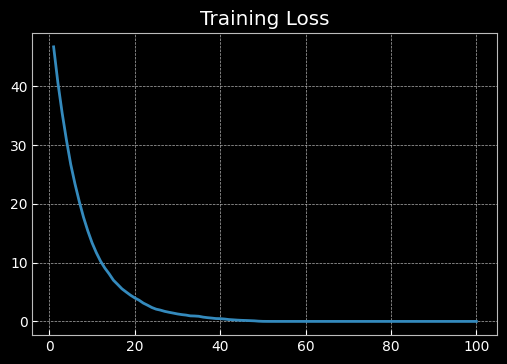

In [34]:
set_default(figsize=(6, 4), dpi=100)
plt.title('Training Loss')
plt.plot(range(1, epochs+1), train_loss_vals)

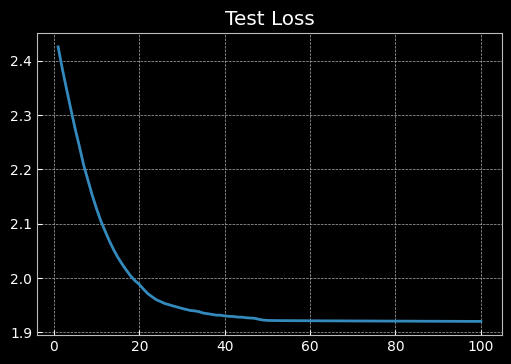

In [35]:
set_default(figsize=(6, 4), dpi=100)
plt.title('Test Loss')
plt.plot(range(1, epochs+1), test_loss_vals)

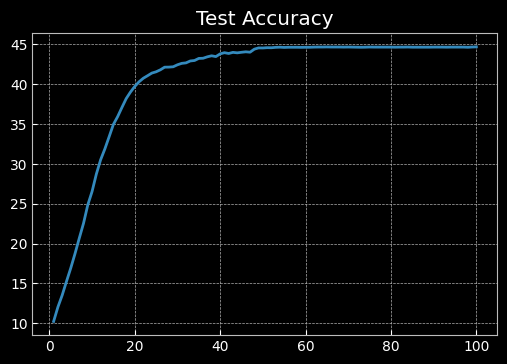

In [36]:
set_default(figsize=(6, 4), dpi=100)
plt.title('Test Accuracy')
plt.plot(range(1, epochs+1), test_accuracies)

In [37]:

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.l1 = nn.Linear(784, 32)
    self.l2 = nn.Linear(32, 16)
    self.l3 = nn.Linear(16, 10)

  def forward(self, x):
    x = x.view(x.shape[0], -1)
    x = F.relu(self.l1(x))
    x = F.relu(self.l2(x))
    x = self.l3(x)
    return F.log_softmax(x, dim=1)

baseline_model = Net().to(device)
print(baseline_model)

Net(
  (l1): Linear(in_features=784, out_features=32, bias=True)
  (l2): Linear(in_features=32, out_features=16, bias=True)
  (l3): Linear(in_features=16, out_features=10, bias=True)
)


In [38]:
criterion = nn.NLLLoss() # the negative log-likelihood loss.
optimizer = torch.optim.SGD(baseline_model.parameters(), lr=0.001, momentum=0.5)

In [39]:
# use a different loader to adjust loading settings
bl_mini_dl = DataLoader(mini_ds, batch_size=5, drop_last=False, shuffle=True, num_workers=1, pin_memory=cuda)

In [40]:

epochs = 100
train_loss_vals, test_loss_vals, test_accuracies = [], [], []
for epoch in range(1, epochs+1):
  # train using only the 100 labeled data points
  baseline_model.train()
  train_loss = 0
  for x, y in bl_mini_dl:
    x = x.to(device)
    y = y.to(device)
    # forward
    y_hat = baseline_model(x)
    loss = criterion(y_hat, y)
    train_loss += loss.item()
    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  
  train_loss /= len(bl_mini_dl.dataset)
  train_loss_vals.append(train_loss)

  # evaluate over the whole test set
  with torch.no_grad():
    baseline_model.eval()
    test_loss = 0
    correct = 0
    for x, y in bin_test_loader:
      x = x.to(device)
      y = y.to(device)

      # forward
      y_hat = baseline_model(x)
      test_loss += F.nll_loss(y_hat, y, reduction='sum').item()  # sum up batch loss
      pred = y_hat.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      correct += pred.eq(y.view_as(pred)).sum().item()
  
  accuracy = 100. * correct / len(bin_test_loader.dataset)
  test_loss /= len(bin_test_loader.dataset)
  test_loss_vals.append(test_loss)
  test_accuracies.append(accuracy)

  if epoch % 10 == 0:
    print(f'===== Epoch {epoch} =====')
    print(f'Average train loss: {train_loss:.4f}')
    print(f'Average test loss: {test_loss:.4f}, Accuracy: {accuracy:.0f}%')

# save avg accuracy to clf_stats
clf_stats['baseline_model'] = max(test_accuracies)

===== Epoch 10 =====
Average train loss: 0.3832
Average test loss: 2.3078, Accuracy: 14%
===== Epoch 20 =====
Average train loss: 0.3552
Average test loss: 2.3051, Accuracy: 14%
===== Epoch 30 =====
Average train loss: 0.3482
Average test loss: 2.3039, Accuracy: 12%
===== Epoch 40 =====
Average train loss: 0.3384
Average test loss: 2.3026, Accuracy: 12%
===== Epoch 50 =====
Average train loss: 0.3323
Average test loss: 2.3007, Accuracy: 13%
===== Epoch 60 =====
Average train loss: 0.3374
Average test loss: 2.2995, Accuracy: 12%
===== Epoch 70 =====
Average train loss: 0.3342
Average test loss: 2.2984, Accuracy: 12%
===== Epoch 80 =====
Average train loss: 0.2741
Average test loss: 2.2923, Accuracy: 11%
===== Epoch 90 =====
Average train loss: 0.2743
Average test loss: 2.2909, Accuracy: 10%
===== Epoch 100 =====
Average train loss: 0.2665
Average test loss: 2.2909, Accuracy: 10%


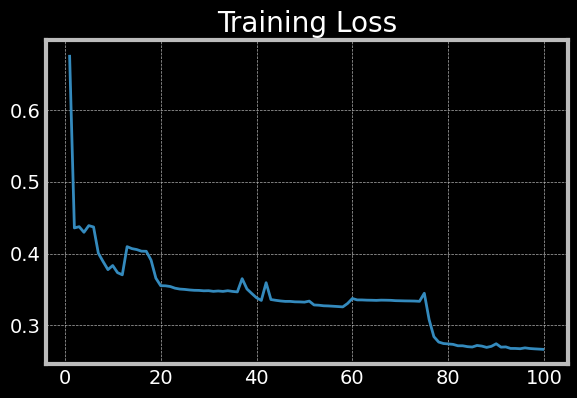

In [42]:
set_default(figsize=(6, 4), dpi=100)
plt.title('Training Loss')
plt.plot(range(1, epochs+1), train_loss_vals)

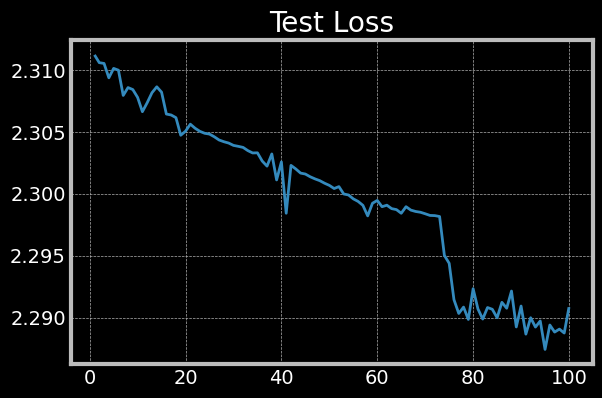

In [43]:
set_default(figsize=(6, 4), dpi=100)
plt.title('Test Loss')
plt.plot(range(1, epochs+1), test_loss_vals)

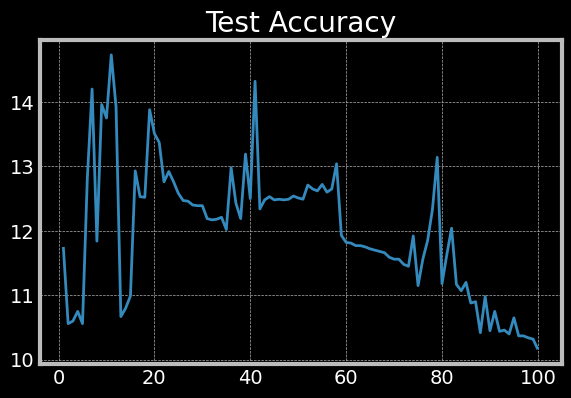

In [44]:
set_default(figsize=(6, 4), dpi=100)
plt.title('Test Accuracy')
plt.plot(range(1, epochs+1), test_accuracies)

In [45]:
clf_stats

{'baseline_model': 14.73, 'm1_linear_model': 44.69}

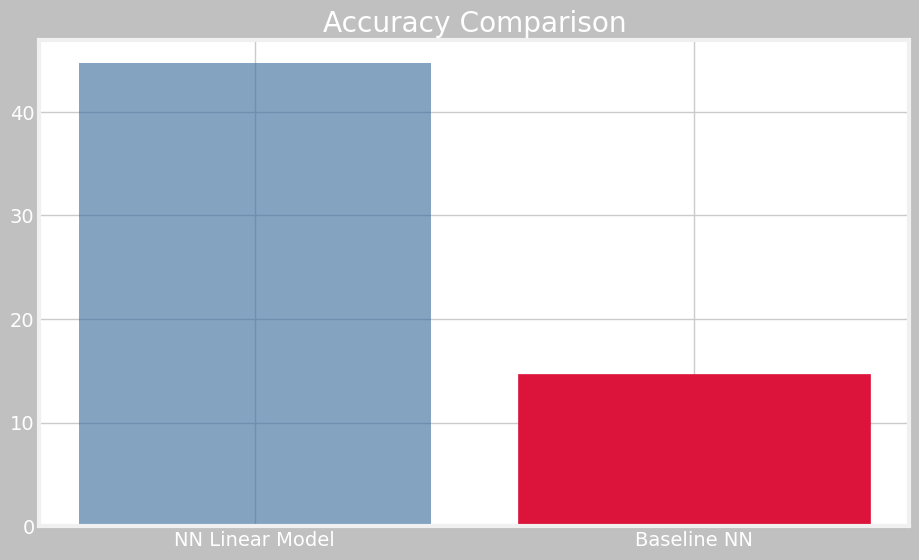

In [41]:
names = list(clf_stats.keys())
values = list(clf_stats.values())

plt.style.use(['fivethirtyeight'])
plt.rc('axes', facecolor='w')
plt.rc('figure', facecolor='silver')
plt.rc('figure', figsize=(10, 6), dpi=100)

plt.title('Accuracy Comparison')
bg = plt.bar(['NN Linear Model', 'Baseline NN'], values, color=(0.2, 0.4, 0.6, 0.6))
bg[1].set_color('crimson')